Visualizing Parameter Space Distribution from Train/Test/Val Splits
Base directory: /project/vil_baek/psaap/processed_cases
Found 350 cases in train split
Found 75 cases in val split
Found 75 cases in test split

PARAMETER SPACE ANALYSIS

Overall Parameter Space:
  Pressure range: 50000 - 168750 Pa
  Density range:  0.500 - 2.000 kg/m³
  Total cases: 500
  Unique pressures: 20
  Unique densities: 25

Split Distribution:
  TRAIN: 350 cases
    Pressure: 50000 - 168750 Pa
    Density:  0.500 - 2.000 kg/m³
  VAL: 75 cases
    Pressure: 100000 - 137500 Pa
    Density:  0.500 - 2.000 kg/m³
  TEST: 75 cases
    Pressure: 50000 - 168750 Pa
    Density:  0.500 - 2.000 kg/m³

Extrapolation Analysis:
  Training bounds:
    Pressure: [50000, 168750] Pa
    Density:  [0.500, 2.000] kg/m³
  Test extrapolation cases: 0/75 (0.0%)
Visualization saved to: /project/vil_baek/psaap/processed_cases/parameter_space_analysis.png
PDF saved to: /project/vil_baek/psaap/processed_cases/parameter_space_analysis.p

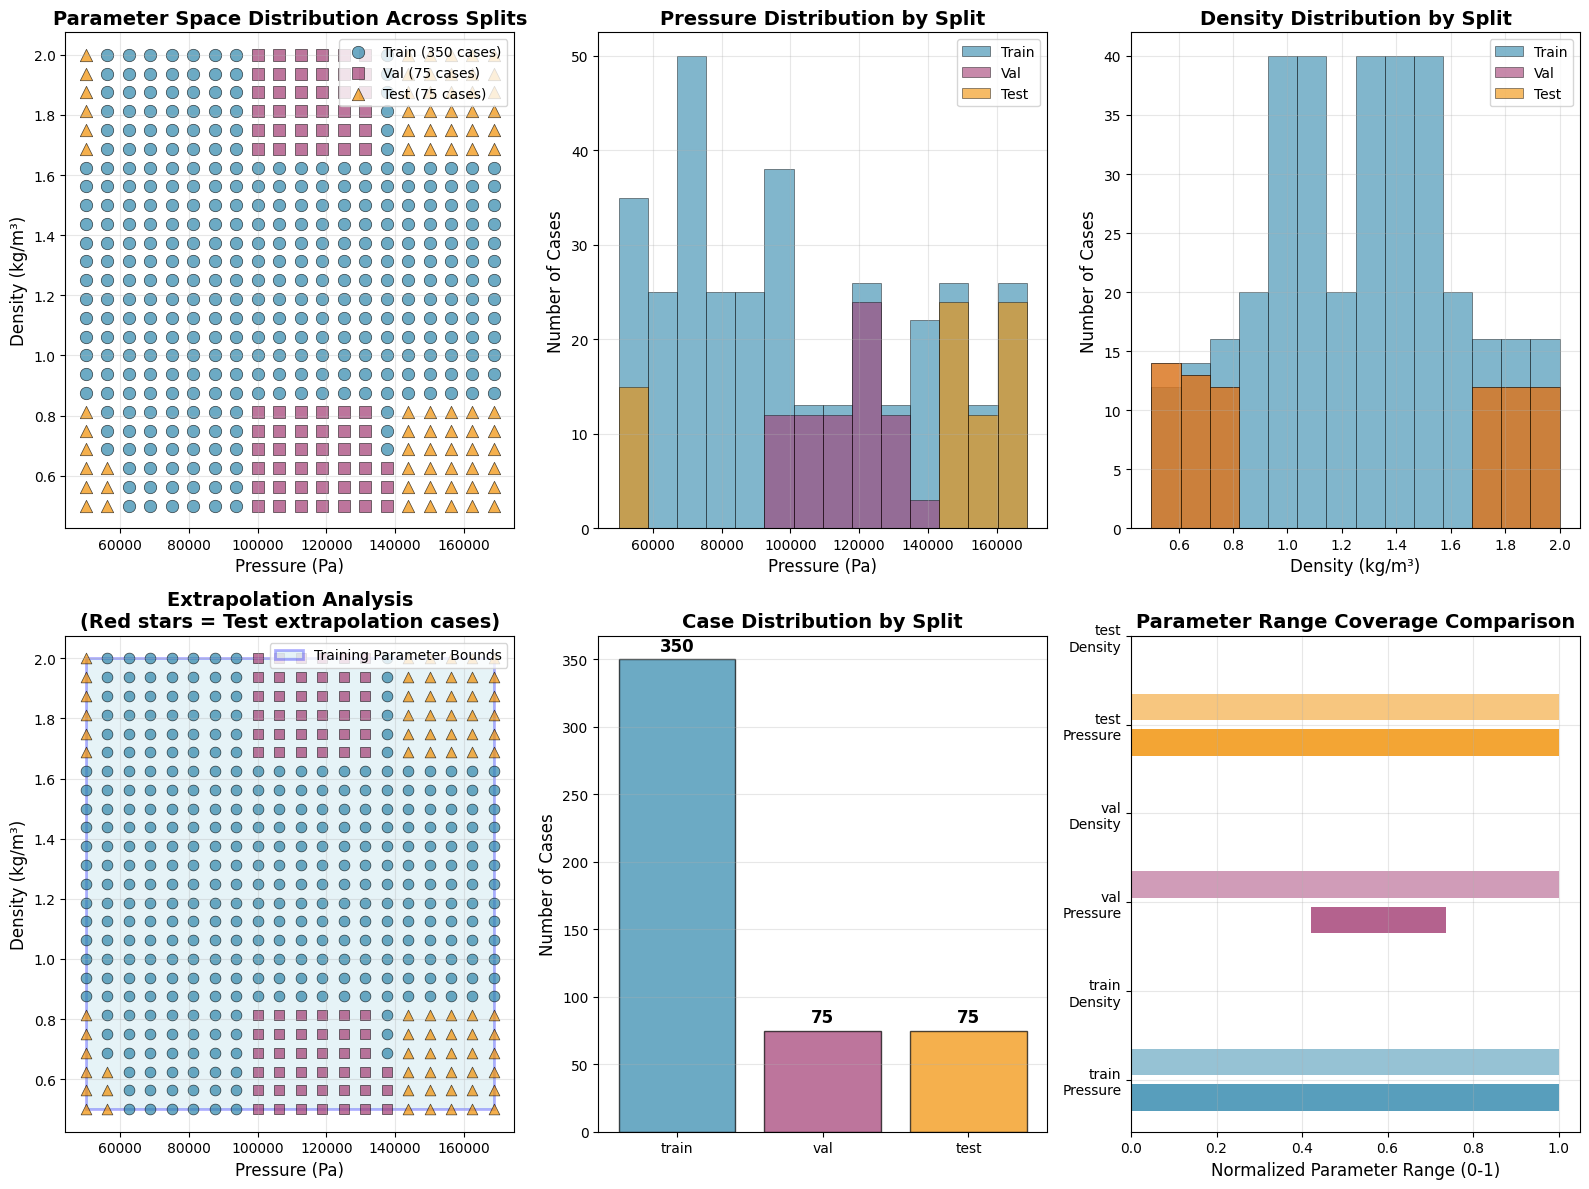

Analysis data saved to: /project/vil_baek/psaap/processed_cases/parameter_split_analysis.json

Visualization complete!


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import defaultdict
import json

class ParameterSplitVisualizer:
    """
    Visualize parameter space distribution from existing train/test/val case directories.
    """
    
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.splits = ['train', 'val', 'test']
        self.colors = {'train': '#2E86AB', 'val': '#A23B72', 'test': '#F18F01'}
        self.markers = {'train': 'o', 'val': 's', 'test': '^'}
        
    def extract_parameters_from_filename(self, filename):
        """Extract pressure and density from case filename."""
        # Pattern: p_L_125000_rho_L_1.5_split_with_pos.pt
        pressure_match = re.search(r'p_L_(\d+)', filename)
        density_match = re.search(r'rho_L_([\d.]+)', filename)
        
        pressure = float(pressure_match.group(1)) if pressure_match else None
        density = float(density_match.group(1)) if density_match else None
        
        return pressure, density
    
    def load_split_parameters(self):
        """Load parameter information from all split directories."""
        split_data = {}
        
        for split in self.splits:
            split_dir = self.base_dir / f"{split}_cases"
            split_data[split] = {'pressures': [], 'densities': [], 'case_names': []}
            
            if not split_dir.exists():
                print(f"Warning: {split_dir} not found, skipping {split} split")
                continue
            
            # Get all .pt files in the split directory
            case_files = list(split_dir.glob("*.pt"))
            print(f"Found {len(case_files)} cases in {split} split")
            
            for case_file in case_files:
                pressure, density = self.extract_parameters_from_filename(case_file.name)
                if pressure is not None and density is not None:
                    split_data[split]['pressures'].append(pressure)
                    split_data[split]['densities'].append(density)
                    # Extract case name (remove split suffix)
                    case_name = case_file.name.replace(f'_{split}_with_pos.pt', '')
                    split_data[split]['case_names'].append(case_name)
        
        return split_data
    
    def analyze_parameter_space(self, split_data):
        """Analyze the parameter space coverage."""
        all_pressures = []
        all_densities = []
        
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
            all_densities.extend(split_data[split]['densities'])
        
        analysis = {
            'pressure_range': [min(all_pressures), max(all_pressures)] if all_pressures else [0, 0],
            'density_range': [min(all_densities), max(all_densities)] if all_densities else [0, 0],
            'unique_pressures': sorted(set(all_pressures)),
            'unique_densities': sorted(set(all_densities)),
            'total_cases': len(all_pressures)
        }
        
        return analysis
    
    def create_visualizations(self, split_data, output_dir=None):
        """Create comprehensive parameter space visualizations."""
        if output_dir is None:
            output_dir = self.base_dir
        
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Parameter space scatter plot
        ax1 = plt.subplot(2, 3, 1)
        for split in self.splits:
            data = split_data[split]
            if data['pressures'] and data['densities']:
                ax1.scatter(data['pressures'], data['densities'], 
                           c=self.colors[split], marker=self.markers[split], 
                           alpha=0.7, s=80, label=f'{split.title()} ({len(data["pressures"])} cases)',
                           edgecolors='black', linewidth=0.5)
        
        ax1.set_xlabel('Pressure (Pa)', fontsize=12)
        ax1.set_ylabel('Density (kg/m³)', fontsize=12)
        ax1.set_title('Parameter Space Distribution Across Splits', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # 2. Pressure distribution histogram
        ax2 = plt.subplot(2, 3, 2)
        all_pressures = []
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
        
        if all_pressures:
            pressure_bins = np.linspace(min(all_pressures), max(all_pressures), 15)
            for split in self.splits:
                data = split_data[split]
                if data['pressures']:
                    ax2.hist(data['pressures'], bins=pressure_bins, alpha=0.6, 
                            color=self.colors[split], label=f'{split.title()}',
                            edgecolor='black', linewidth=0.5)
        
        ax2.set_xlabel('Pressure (Pa)', fontsize=12)
        ax2.set_ylabel('Number of Cases', fontsize=12)
        ax2.set_title('Pressure Distribution by Split', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # 3. Density distribution histogram
        ax3 = plt.subplot(2, 3, 3)
        all_densities = []
        for split in self.splits:
            all_densities.extend(split_data[split]['densities'])
        
        if all_densities:
            density_bins = np.linspace(min(all_densities), max(all_densities), 15)
            for split in self.splits:
                data = split_data[split]
                if data['densities']:
                    ax3.hist(data['densities'], bins=density_bins, alpha=0.6, 
                            color=self.colors[split], label=f'{split.title()}',
                            edgecolor='black', linewidth=0.5)
        
        ax3.set_xlabel('Density (kg/m³)', fontsize=12)
        ax3.set_ylabel('Number of Cases', fontsize=12)
        ax3.set_title('Density Distribution by Split', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # 4. Training bounds analysis
        ax4 = plt.subplot(2, 3, 4)
        
        # Get training bounds
        train_data = split_data['train']
        if train_data['pressures'] and train_data['densities']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            
            # Draw training bounds rectangle
            from matplotlib.patches import Rectangle
            rect = Rectangle((train_p_min, train_d_min), 
                           train_p_max - train_p_min, 
                           train_d_max - train_d_min,
                           linewidth=2, edgecolor='blue', 
                           facecolor='lightblue', alpha=0.3,
                           label='Training Parameter Bounds')
            ax4.add_patch(rect)
            
            # Plot all points with extrapolation highlighting
            for split in self.splits:
                data = split_data[split]
                for p, d in zip(data['pressures'], data['densities']):
                    is_extrapolation = (p < train_p_min or p > train_p_max or 
                                      d < train_d_min or d > train_d_max)
                    
                    if split == 'test' and is_extrapolation:
                        # Highlight test extrapolation cases
                        ax4.scatter(p, d, c='red', marker='*', s=150, 
                                  edgecolors='black', linewidth=1, 
                                  label='Test Extrapolation' if p == data['pressures'][0] else "")
                    else:
                        ax4.scatter(p, d, c=self.colors[split], 
                                  marker=self.markers[split], alpha=0.7, s=60,
                                  edgecolors='black', linewidth=0.5)
        
        ax4.set_xlabel('Pressure (Pa)', fontsize=12)
        ax4.set_ylabel('Density (kg/m³)', fontsize=12)
        ax4.set_title('Extrapolation Analysis\n(Red stars = Test extrapolation cases)', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        # 5. Case count comparison
        ax5 = plt.subplot(2, 3, 5)
        
        split_names = [split for split in self.splits if split_data[split]['pressures']]
        case_counts = [len(split_data[split]['pressures']) for split in split_names]
        
        bars = ax5.bar(split_names, case_counts, 
                      color=[self.colors[split] for split in split_names],
                      alpha=0.7, edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for bar, count in zip(bars, case_counts):
            ax5.annotate(f'{count}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax5.set_ylabel('Number of Cases', fontsize=12)
        ax5.set_title('Case Distribution by Split', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 6. Parameter range coverage
        ax6 = plt.subplot(2, 3, 6)
        
        # Create range comparison
        y_positions = np.arange(len(self.splits))
        
        for i, split in enumerate(self.splits):
            data = split_data[split]
            if data['pressures'] and data['densities']:
                p_min, p_max = min(data['pressures']), max(data['pressures'])
                d_min, d_max = min(data['densities']), max(data['densities'])
                
                # Normalize to 0-1 for visualization
                all_p = []
                all_d = []
                for s in self.splits:
                    all_p.extend(split_data[s]['pressures'])
                    all_d.extend(split_data[s]['densities'])
                
                if all_p and all_d:
                    global_p_min, global_p_max = min(all_p), max(all_p)
                    global_d_min, global_d_max = min(all_d), max(all_d)
                    
                    p_norm_min = (p_min - global_p_min) / (global_p_max - global_p_min) if global_p_max > global_p_min else 0
                    p_norm_max = (p_max - global_p_min) / (global_p_max - global_p_min) if global_p_max > global_p_min else 0
                    
                    ax6.barh(i*2, p_norm_max - p_norm_min, left=p_norm_min, height=0.3,
                            color=self.colors[split], alpha=0.8, 
                            label=f'{split} Pressure' if i == 0 else "")
                    
                    d_norm_min = (d_min - global_d_min) / (global_d_max - global_d_min) if global_d_max > global_d_min else 0
                    d_norm_max = (d_max - global_d_min) / (global_d_max - global_d_min) if global_d_max > global_d_min else 0
                    
                    ax6.barh(i*2+0.4, d_norm_max - d_norm_min, left=d_norm_min, height=0.3,
                            color=self.colors[split], alpha=0.5,
                            label=f'{split} Density' if i == 0 else "")
        
        ax6.set_yticks(np.arange(len(self.splits)*2) + 0.2)
        ax6.set_yticklabels([f'{split}\nPressure' if i%2==0 else f'{split}\nDensity' 
                            for split in self.splits for i in range(2)])
        ax6.set_xlabel('Normalized Parameter Range (0-1)', fontsize=12)
        ax6.set_title('Parameter Range Coverage Comparison', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the visualization
        output_path = Path(output_dir)
        viz_file = output_path / 'parameter_space_analysis.png'
        plt.savefig(viz_file, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {viz_file}")
        
        # Also save as PDF
        viz_file_pdf = output_path / 'parameter_space_analysis.pdf'
        plt.savefig(viz_file_pdf, bbox_inches='tight')
        print(f"PDF saved to: {viz_file_pdf}")
        
        plt.show()
        
        return fig
    
    def print_parameter_analysis(self, split_data, analysis):
        """Print detailed parameter analysis to console."""
        print("\n" + "="*80)
        print("PARAMETER SPACE ANALYSIS")
        print("="*80)
        
        print(f"\nOverall Parameter Space:")
        print(f"  Pressure range: {analysis['pressure_range'][0]:.0f} - {analysis['pressure_range'][1]:.0f} Pa")
        print(f"  Density range:  {analysis['density_range'][0]:.3f} - {analysis['density_range'][1]:.3f} kg/m³")
        print(f"  Total cases: {analysis['total_cases']}")
        print(f"  Unique pressures: {len(analysis['unique_pressures'])}")
        print(f"  Unique densities: {len(analysis['unique_densities'])}")
        
        print(f"\nSplit Distribution:")
        for split in self.splits:
            data = split_data[split]
            if data['pressures']:
                p_range = f"{min(data['pressures']):.0f} - {max(data['pressures']):.0f}"
                d_range = f"{min(data['densities']):.3f} - {max(data['densities']):.3f}"
                print(f"  {split.upper()}: {len(data['pressures'])} cases")
                print(f"    Pressure: {p_range} Pa")
                print(f"    Density:  {d_range} kg/m³")
            else:
                print(f"  {split.upper()}: No cases found")
        
        # Extrapolation analysis
        train_data = split_data['train']
        test_data = split_data['test']
        
        if train_data['pressures'] and test_data['pressures']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            
            test_extrapolation_cases = 0
            for p, d in zip(test_data['pressures'], test_data['densities']):
                if p < train_p_min or p > train_p_max or d < train_d_min or d > train_d_max:
                    test_extrapolation_cases += 1
            
            print(f"\nExtrapolation Analysis:")
            print(f"  Training bounds:")
            print(f"    Pressure: [{train_p_min:.0f}, {train_p_max:.0f}] Pa")
            print(f"    Density:  [{train_d_min:.3f}, {train_d_max:.3f}] kg/m³")
            print(f"  Test extrapolation cases: {test_extrapolation_cases}/{len(test_data['pressures'])} ({test_extrapolation_cases/len(test_data['pressures'])*100:.1f}%)")
    
    def save_analysis_json(self, split_data, analysis, output_dir=None):
        """Save analysis results as JSON."""
        if output_dir is None:
            output_dir = self.base_dir
        
        output_data = {
            'parameter_analysis': analysis,
            'split_data': split_data,
            'timestamp': str(np.datetime64('now'))
        }
        
        json_file = Path(output_dir) / 'parameter_split_analysis.json'
        with open(json_file, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"Analysis data saved to: {json_file}")


def main():
    """Main execution function."""
    BASE_DIR = "/project/vil_baek/psaap/processed_cases"
    
    print("Visualizing Parameter Space Distribution from Train/Test/Val Splits")
    print("="*80)
    print(f"Base directory: {BASE_DIR}")
    
    # Initialize visualizer
    visualizer = ParameterSplitVisualizer(BASE_DIR)
    
    # Load parameter data from split directories
    split_data = visualizer.load_split_parameters()
    
    # Analyze parameter space
    analysis = visualizer.analyze_parameter_space(split_data)
    
    # Print analysis
    visualizer.print_parameter_analysis(split_data, analysis)
    
    # Create visualizations
    visualizer.create_visualizations(split_data)
    
    # Save analysis as JSON
    visualizer.save_analysis_json(split_data, analysis)
    
    print("\nVisualization complete!")


if __name__ == "__main__":
    main()

Analyzing Timestep Variations in HDF5 Shock Tube Data

Exploring HDF5 file structure...
Exploring structure of: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases/p_L_50000/rho_L_1.1875/plot/shockTube.plot.000028.2d.hdf5
HDF5 File Structure:
----------------------------------------
Chombo_global: Group
  @SpaceDim: 2
  @testReal: 0.0
Expressions: Group
  @scalar R: b'zonal_constant(Mesh,287.000000)'
  @scalar cart_vorticity: b'curl(velocity)'
  @scalar gamma: b'zonal_constant(Mesh,1.400000)'
  @scalar kinetic_energy: b'dot(velocity,velocity)/2'
  @scalar log10entropy: b'log10(pressure) - gamma*log10(<density>)'
  @scalar machnumber: b'magnitude(<velocity>)/<soundspeed>'
  @scalar pressure: b'(gamma-1)*(<energy-density>-kinetic_energy*density)'
  @scalar soundspeed: b'sqrt(gamma*(pressure/density))'
  @scalar temperature: b'pressure/(R*density)'
  @scalar x-velocity: b'<x-momentum>/density'
  @scalar y-velocity: b'<y-momentum>/density'
  @vector 

Discovering cases in: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases
Analyzing case p_L_100000_rho_L_0.5 (44 files)...
Analyzing case p_L_100000_rho_L_0.5625 (44 files)...
Analyzing case p_L_100000_rho_L_0.625 (44 files)...
Analyzing case p_L_100000_rho_L_0.6875 (44 files)...
Analyzing case p_L_100000_rho_L_0.75 (44 files)...
Analyzing case p_L_100000_rho_L_0.8125 (44 files)...
Analyzing case p_L_100000_rho_L_0.875 (44 files)...
Analyzing case p_L_100000_rho_L_0.9375 (44 files)...
Analyzing case p_L_100000_rho_L_1.0 (44 files)...
Analyzing case p_L_100000_rho_L_1.0625 (44 files)...
Analyzing case p_L_100000_rho_L_1.125 (44 files)...
Analyzing case p_L_100000_rho_L_1.1875 (44 files)...
Analyzing case p_L_100000_rho_L_1.25 (44 files)...
Analyzing case p_L_100000_rho_L_1.3125 (44 files)...
Analyzing case p_L_100000_rho_L_1.375 (44 files)...
Analyzing case p_L_100000_rho_L_1.4375 (44 files)...
Analyzing case p_L_100000_rho_L_1.5 (44 files)...
An

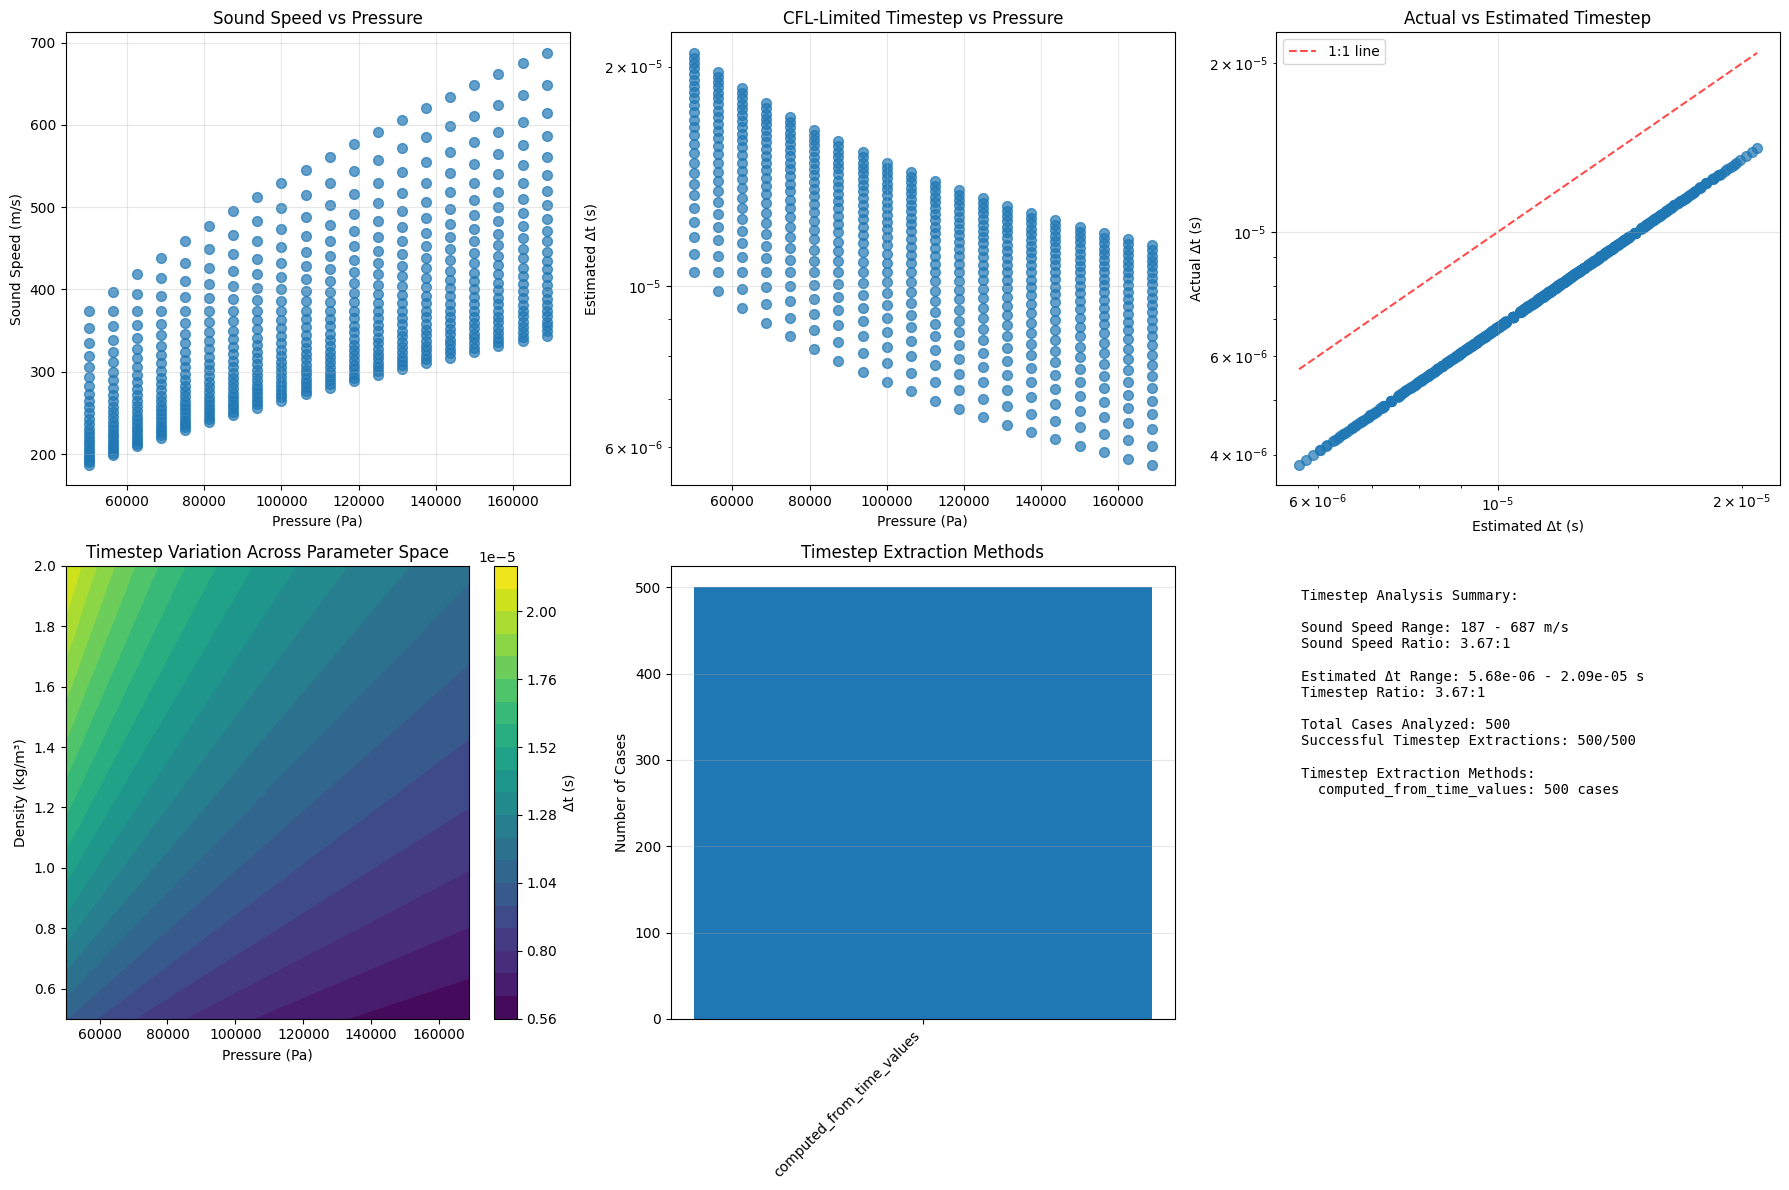

Complete timestep analysis saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/hdf5_timestep_analysis.json

Timestep Analysis Summary:
  Total cases: 500
  Successful extractions: 500
  Extraction methods: {'computed_from_time_values': 500}
  Estimated timestep range: 5.68e-06 - 2.09e-05 s
  Timestep variation ratio: 3.67:1


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import json
from collections import defaultdict

class HDF5TimestepAnalyzer:
    """
    Analyze timestep variations from raw HDF5 shock tube simulation files.
    """
    
    def __init__(self, base_data_dir):
        self.base_data_dir = Path(base_data_dir)
        self.timestep_data = {}
        
    def explore_hdf5_structure(self, sample_file):
        """Explore the structure of an HDF5 file to understand data organization."""
        print(f"Exploring structure of: {sample_file}")
        
        def print_structure(name, obj):
            indent = "  " * name.count('/')
            if isinstance(obj, h5py.Dataset):
                print(f"{indent}{name}: Dataset {obj.shape} {obj.dtype}")
                # Print first few values for small datasets
                if obj.size < 20:
                    print(f"{indent}  Values: {obj[()]}")
                # Print attributes
                for attr_name, attr_val in obj.attrs.items():
                    print(f"{indent}  @{attr_name}: {attr_val}")
            elif isinstance(obj, h5py.Group):
                print(f"{indent}{name}: Group")
                for attr_name, attr_val in obj.attrs.items():
                    print(f"{indent}  @{attr_name}: {attr_val}")
        
        try:
            with h5py.File(sample_file, 'r') as f:
                print("HDF5 File Structure:")
                print("-" * 40)
                f.visititems(print_structure)
                
                # Check root attributes
                if f.attrs:
                    print("\nRoot Attributes:")
                    for attr_name, attr_val in f.attrs.items():
                        print(f"  @{attr_name}: {attr_val}")
                        
        except Exception as e:
            print(f"Error reading HDF5 file: {e}")
    
    def extract_timestep_from_filename(self, filename):
        """Extract timestep number from filename pattern."""
        # Pattern: *.plot.NNNNNN.2d.hdf5
        match = re.search(r'\.plot\.(\d+)\.2d\.hdf5', str(filename))
        return int(match.group(1)) if match else None
    
    def extract_timestep_from_hdf5(self, hdf5_file):
        """Extract timestep information from HDF5 file."""
        timestep_info = {}
        
        try:
            with h5py.File(hdf5_file, 'r') as f:
                # Common locations for timestep data in CFD HDF5 files
                possible_time_locations = [
                    'time',           # Direct time value
                    'TIME',
                    'current_time',
                    'simulation_time',
                    'Time',
                    'dt',             # Timestep size
                    'timestep',
                    'delta_t',
                    'time_step'
                ]
                
                # Check root attributes first
                for attr_name in possible_time_locations:
                    if attr_name in f.attrs:
                        timestep_info[f'attr_{attr_name}'] = float(f.attrs[attr_name])
                
                # Check for time datasets
                for time_name in possible_time_locations:
                    if time_name in f:
                        time_data = f[time_name]
                        if isinstance(time_data, h5py.Dataset):
                            timestep_info[f'dataset_{time_name}'] = float(time_data[()])
                
                # Check level_0 group (common in Chombo/AMR codes)
                if 'level_0' in f:
                    level_group = f['level_0']
                    for attr_name in possible_time_locations:
                        if attr_name in level_group.attrs:
                            timestep_info[f'level0_attr_{attr_name}'] = float(level_group.attrs[attr_name])
                
                # Check for other common CFD metadata locations
                metadata_groups = ['metadata', 'header', 'parameters', 'simulation_info']
                for group_name in metadata_groups:
                    if group_name in f:
                        group = f[group_name]
                        for attr_name in possible_time_locations:
                            if attr_name in group.attrs:
                                timestep_info[f'{group_name}_{attr_name}'] = float(group.attrs[attr_name])
                
                # Extract filename-based timestep
                filename_timestep = self.extract_timestep_from_filename(hdf5_file.name)
                if filename_timestep is not None:
                    timestep_info['filename_timestep'] = filename_timestep
                    
        except Exception as e:
            print(f"Error reading {hdf5_file}: {e}")
            
        return timestep_info
    
    def get_case_files(self, case_dir):
        """Get sorted list of HDF5 files for a case."""
        files = list(case_dir.glob('*.plot.*.2d.hdf5'))
        # Sort by timestep number in filename
        return sorted(files, key=lambda f: self.extract_timestep_from_filename(f.name) or 0)
    
    def analyze_case_timesteps(self, case_dir, case_name):
        """Analyze timestep information for a single case."""
        files = self.get_case_files(case_dir)
        if len(files) < 2:
            print(f"Warning: Case {case_name} has insufficient files ({len(files)})")
            return None
        
        print(f"Analyzing case {case_name} ({len(files)} files)...")
        
        case_timestep_data = []
        
        for i, file_path in enumerate(files):
            timestep_info = self.extract_timestep_from_hdf5(file_path)
            
            # Add filename info
            timestep_info['file_index'] = i
            timestep_info['filename'] = file_path.name
            
            case_timestep_data.append(timestep_info)
        
        # Analyze timestep pattern
        analysis = self.analyze_timestep_pattern(case_timestep_data, case_name)
        
        return {
            'raw_data': case_timestep_data,
            'analysis': analysis
        }
    
    def analyze_timestep_pattern(self, timestep_data, case_name):
        """Analyze the timestep pattern from extracted data."""
        analysis = {
            'total_files': len(timestep_data),
            'timestep_method': 'unknown',
            'dt_values': [],
            'time_values': [],
            'filename_timesteps': []
        }
        
        # Extract values from different sources
        for data in timestep_data:
            # Try to find actual simulation time
            time_value = None
            for key in data:
                if 'time' in key.lower() and 'step' not in key.lower():
                    time_value = data[key]
                    break
            
            if time_value is not None:
                analysis['time_values'].append(time_value)
            
            # Try to find dt values
            dt_value = None
            for key in data:
                if any(dt_key in key.lower() for dt_key in ['dt', 'delta_t', 'timestep']):
                    dt_value = data[key]
                    break
            
            if dt_value is not None:
                analysis['dt_values'].append(dt_value)
            
            # Filename timesteps
            if 'filename_timestep' in data:
                analysis['filename_timesteps'].append(data['filename_timestep'])
        
        # Compute timestep statistics
        if len(analysis['time_values']) > 1:
            time_diffs = np.diff(analysis['time_values'])
            analysis['computed_dt'] = {
                'mean': float(np.mean(time_diffs)),
                'std': float(np.std(time_diffs)),
                'min': float(np.min(time_diffs)),
                'max': float(np.max(time_diffs)),
                'values': time_diffs.tolist()
            }
            analysis['timestep_method'] = 'computed_from_time_values'
            analysis['total_simulation_time'] = float(analysis['time_values'][-1] - analysis['time_values'][0])
        
        elif len(analysis['dt_values']) > 0:
            # Use stored dt values
            dt_array = np.array(analysis['dt_values'])
            analysis['stored_dt'] = {
                'mean': float(np.mean(dt_array)),
                'std': float(np.std(dt_array)),
                'min': float(np.min(dt_array)),
                'max': float(np.max(dt_array)),
                'values': dt_array.tolist()
            }
            analysis['timestep_method'] = 'stored_dt_values'
            analysis['total_simulation_time'] = float(np.sum(dt_array))
        
        else:
            print(f"Warning: No timestep information found for {case_name}")
            analysis['timestep_method'] = 'unavailable'
        
        return analysis
    
    def discover_and_analyze_all_cases(self):
        """Discover and analyze timestep information for all cases."""
        print(f"Discovering cases in: {self.base_data_dir}")
        
        # Navigate hierarchical structure: p_L_* / rho_L_* / plot /
        pressure_dirs = sorted([d for d in self.base_data_dir.iterdir() 
                               if d.is_dir() and d.name.startswith('p_L_')])
        
        all_results = {}
        
        for p_dir in pressure_dirs:
            pressure_val = p_dir.name
            density_dirs = sorted([d for d in p_dir.iterdir() 
                                 if d.is_dir() and d.name.startswith('rho_L_')])
            
            for rho_dir in density_dirs:
                density_val = rho_dir.name
                plot_dir = rho_dir / 'plot'
                
                if plot_dir.exists() and plot_dir.is_dir():
                    hdf5_files = list(plot_dir.glob('*.plot.*.2d.hdf5'))
                    if hdf5_files:
                        case_name = f"{pressure_val}_{density_val}"
                        
                        # Extract parameter values
                        pressure_match = re.search(r'p_L_(\d+)', pressure_val)
                        density_match = re.search(r'rho_L_([\d.]+)', density_val)
                        
                        pressure_numeric = float(pressure_match.group(1)) if pressure_match else None
                        density_numeric = float(density_match.group(1)) if density_match else None
                        
                        # Analyze timesteps for this case
                        case_result = self.analyze_case_timesteps(plot_dir, case_name)
                        
                        if case_result:
                            case_result['parameters'] = {
                                'pressure_str': pressure_val,
                                'density_str': density_val,
                                'pressure_numeric': pressure_numeric,
                                'density_numeric': density_numeric
                            }
                            all_results[case_name] = case_result
        
        self.timestep_data = all_results
        return all_results
    
    def estimate_cfl_constraints(self, results):
        """Estimate CFL-based timestep constraints for shock tube cases."""
        for case_name, case_data in results.items():
            params = case_data['parameters']
            p_left = params['pressure_numeric']  # Left state pressure
            rho_left = params['density_numeric']  # Left state density
            
            if p_left and rho_left:
                # Shock tube setup: L indicates left state (high pressure/density)
                # Pressure ratio L:R = 10:1, Density ratio L:R = 8:1
                p_right = p_left / 10.0
                rho_right = rho_left / 8.0
                
                # Sound speeds in left and right regions (ideal gas, γ=1.4)
                gamma = 1.4
                c_left = np.sqrt(gamma * p_left / rho_left)
                c_right = np.sqrt(gamma * p_right / rho_right)
                c_max = max(c_left, c_right)  # Most restrictive for CFL
                
                # Grid spacing for 64x64 mesh on 0.5x0.5m domain
                dx = 0.5 / 64  # ≈ 0.0078 m
                
                # CFL constraints (most restrictive determines timestep)
                cfl_05 = 0.5 * dx / c_max
                cfl_01 = 0.1 * dx / c_max
                
                # Estimate shock speed using Rankine-Hugoniot relations
                # For strong shocks: u_s ≈ sqrt(gamma * p_left / rho_right)
                shock_speed_estimate = np.sqrt(gamma * p_left / rho_right)
                cfl_shock = 0.5 * dx / shock_speed_estimate
                
                case_data['cfl_estimates'] = {
                    'left_sound_speed': c_left,
                    'right_sound_speed': c_right,
                    'max_sound_speed': c_max,
                    'shock_speed_estimate': shock_speed_estimate,
                    'dx': dx,
                    'dt_cfl_0.5_acoustic': cfl_05,
                    'dt_cfl_0.1_acoustic': cfl_01,
                    'dt_cfl_0.5_shock': cfl_shock,
                    'max_stable_dt': min(cfl_05, cfl_shock),
                    'pressure_ratio': p_left / p_right,
                    'density_ratio': rho_left / rho_right
                }
        
        return results
    
    def create_timestep_visualizations(self, results, output_dir=None):
        """Create comprehensive timestep analysis visualizations."""
        if output_dir is None:
            output_dir = self.base_data_dir.parent
        
        # Extract data for plotting
        pressures = []
        densities = []
        actual_dts = []
        estimated_dts = []
        sound_speeds = []
        case_names = []
        
        for case_name, case_data in results.items():
            params = case_data['parameters']
            if params['pressure_numeric'] and params['density_numeric']:
                pressures.append(params['pressure_numeric'])
                densities.append(params['density_numeric'])
                case_names.append(case_name)
                
                # Actual timestep
                analysis = case_data['analysis']
                if 'computed_dt' in analysis:
                    actual_dts.append(analysis['computed_dt']['mean'])
                elif 'stored_dt' in analysis:
                    actual_dts.append(analysis['stored_dt']['mean'])
                else:
                    actual_dts.append(None)
                
                # Estimated timestep and sound speed
                if 'cfl_estimates' in case_data:
                    estimated_dts.append(case_data['cfl_estimates']['dt_cfl_0.5_acoustic'])
                    sound_speeds.append(case_data['cfl_estimates']['max_sound_speed'])
                else:
                    estimated_dts.append(None)
                    sound_speeds.append(None)
        
        # Create visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Sound speed vs pressure
        if sound_speeds and pressures:
            valid_indices = [i for i, s in enumerate(sound_speeds) if s is not None]
            if valid_indices:
                p_vals = [pressures[i] for i in valid_indices]
                s_vals = [sound_speeds[i] for i in valid_indices]
                axes[0,0].scatter(p_vals, s_vals, alpha=0.7, s=50)
                axes[0,0].set_xlabel('Pressure (Pa)')
                axes[0,0].set_ylabel('Sound Speed (m/s)')
                axes[0,0].set_title('Sound Speed vs Pressure')
                axes[0,0].grid(True, alpha=0.3)
        
        # 2. Estimated timestep vs pressure
        if estimated_dts and pressures:
            valid_indices = [i for i, dt in enumerate(estimated_dts) if dt is not None]
            if valid_indices:
                p_vals = [pressures[i] for i in valid_indices]
                dt_vals = [estimated_dts[i] for i in valid_indices]
                axes[0,1].scatter(p_vals, dt_vals, alpha=0.7, s=50)
                axes[0,1].set_xlabel('Pressure (Pa)')
                axes[0,1].set_ylabel('Estimated Δt (s)')
                axes[0,1].set_title('CFL-Limited Timestep vs Pressure')
                axes[0,1].set_yscale('log')
                axes[0,1].grid(True, alpha=0.3)
        
        # 3. Actual vs estimated timestep
        if actual_dts and estimated_dts:
            valid_indices = [i for i in range(len(actual_dts)) 
                           if actual_dts[i] is not None and estimated_dts[i] is not None]
            if valid_indices:
                actual_vals = [actual_dts[i] for i in valid_indices]
                est_vals = [estimated_dts[i] for i in valid_indices]
                
                axes[0,2].scatter(est_vals, actual_vals, alpha=0.7, s=50)
                axes[0,2].plot([min(est_vals), max(est_vals)], 
                              [min(est_vals), max(est_vals)], 'r--', alpha=0.7, label='1:1 line')
                axes[0,2].set_xlabel('Estimated Δt (s)')
                axes[0,2].set_ylabel('Actual Δt (s)')
                axes[0,2].set_title('Actual vs Estimated Timestep')
                axes[0,2].set_xscale('log')
                axes[0,2].set_yscale('log')
                axes[0,2].legend()
                axes[0,2].grid(True, alpha=0.3)
        
        # 4. Timestep variation across parameter space
        if pressures and densities and estimated_dts:
            # Create contour plot
            pressure_unique = sorted(set(p for p in pressures if p is not None))
            density_unique = sorted(set(d for d in densities if d is not None))
            
            if len(pressure_unique) > 2 and len(density_unique) > 2:
                P, D = np.meshgrid(pressure_unique, density_unique)
                gamma = 1.4
                C = np.sqrt(gamma * P / D)
                dx = 0.5 / 64
                DT = 0.5 * dx / C
                
                contour = axes[1,0].contourf(P, D, DT, levels=20, cmap='viridis')
                axes[1,0].set_xlabel('Pressure (Pa)')
                axes[1,0].set_ylabel('Density (kg/m³)')
                axes[1,0].set_title('Timestep Variation Across Parameter Space')
                plt.colorbar(contour, ax=axes[1,0], label='Δt (s)')
        
        # 5. Timestep method distribution
        methods = [results[case]['analysis']['timestep_method'] for case in results]
        method_counts = {}
        for method in methods:
            method_counts[method] = method_counts.get(method, 0) + 1
        
        if method_counts:
            axes[1,1].bar(range(len(method_counts)), list(method_counts.values()))
            axes[1,1].set_xticks(range(len(method_counts)))
            axes[1,1].set_xticklabels(list(method_counts.keys()), rotation=45, ha='right')
            axes[1,1].set_ylabel('Number of Cases')
            axes[1,1].set_title('Timestep Extraction Methods')
            axes[1,1].grid(True, alpha=0.3, axis='y')
        
        # 6. Summary statistics
        axes[1,2].axis('off')
        
        stats_text = "Timestep Analysis Summary:\n\n"
        
        if sound_speeds:
            valid_speeds = [s for s in sound_speeds if s is not None]
            if valid_speeds:
                stats_text += f"Sound Speed Range: {min(valid_speeds):.0f} - {max(valid_speeds):.0f} m/s\n"
                stats_text += f"Sound Speed Ratio: {max(valid_speeds)/min(valid_speeds):.2f}:1\n\n"
        
        if estimated_dts:
            valid_dts = [dt for dt in estimated_dts if dt is not None]
            if valid_dts:
                stats_text += f"Estimated Δt Range: {min(valid_dts):.2e} - {max(valid_dts):.2e} s\n"
                stats_text += f"Timestep Ratio: {max(valid_dts)/min(valid_dts):.2f}:1\n\n"
        
        stats_text += f"Total Cases Analyzed: {len(results)}\n"
        
        # Count successful extractions
        successful_extractions = sum(1 for case in results.values() 
                                   if case['analysis']['timestep_method'] != 'unavailable')
        stats_text += f"Successful Timestep Extractions: {successful_extractions}/{len(results)}\n\n"
        
        stats_text += "Timestep Extraction Methods:\n"
        for method, count in method_counts.items():
            stats_text += f"  {method}: {count} cases\n"
        
        axes[1,2].text(0.05, 0.95, stats_text, transform=axes[1,2].transAxes, 
                      verticalalignment='top', fontsize=10, fontfamily='monospace')
        
        plt.tight_layout()
        
        # Save visualization
        output_path = Path(output_dir)
        viz_file = output_path / 'hdf5_timestep_analysis.png'
        plt.savefig(viz_file, dpi=300, bbox_inches='tight')
        print(f"Timestep analysis saved to: {viz_file}")
        
        plt.show()
        
        return fig
    
    def save_timestep_analysis(self, results, output_dir=None):
        """Save complete timestep analysis as JSON."""
        if output_dir is None:
            output_dir = self.base_data_dir.parent
        
        # Create summary statistics
        summary = {
            'total_cases': len(results),
            'analysis_timestamp': str(np.datetime64('now')),
            'successful_extractions': 0,
            'timestep_methods': {},
            'parameter_ranges': {
                'pressure': {'min': float('inf'), 'max': float('-inf'), 'values': []},
                'density': {'min': float('inf'), 'max': float('-inf'), 'values': []}
            },
            'timestep_statistics': {
                'estimated_dt_range': None,
                'actual_dt_range': None,
                'sound_speed_range': None
            }
        }
        
        # Analyze results
        actual_dts = []
        estimated_dts = []
        sound_speeds = []
        
        for case_name, case_data in results.items():
            # Count extraction methods
            method = case_data['analysis']['timestep_method']
            summary['timestep_methods'][method] = summary['timestep_methods'].get(method, 0) + 1
            
            if method != 'unavailable':
                summary['successful_extractions'] += 1
            
            # Parameter ranges
            params = case_data['parameters']
            if params['pressure_numeric']:
                p = params['pressure_numeric']
                summary['parameter_ranges']['pressure']['values'].append(p)
                summary['parameter_ranges']['pressure']['min'] = min(summary['parameter_ranges']['pressure']['min'], p)
                summary['parameter_ranges']['pressure']['max'] = max(summary['parameter_ranges']['pressure']['max'], p)
            
            if params['density_numeric']:
                d = params['density_numeric']
                summary['parameter_ranges']['density']['values'].append(d)
                summary['parameter_ranges']['density']['min'] = min(summary['parameter_ranges']['density']['min'], d)
                summary['parameter_ranges']['density']['max'] = max(summary['parameter_ranges']['density']['max'], d)
            
            # Timestep data
            if 'computed_dt' in case_data['analysis']:
                actual_dts.append(case_data['analysis']['computed_dt']['mean'])
            elif 'stored_dt' in case_data['analysis']:
                actual_dts.append(case_data['analysis']['stored_dt']['mean'])
            
            if 'cfl_estimates' in case_data:
                estimated_dts.append(case_data['cfl_estimates']['dt_cfl_0.5_acoustic'])
                sound_speeds.append(case_data['cfl_estimates']['max_sound_speed'])
        
        # Finalize statistics
        if actual_dts:
            summary['timestep_statistics']['actual_dt_range'] = [min(actual_dts), max(actual_dts)]
        if estimated_dts:
            summary['timestep_statistics']['estimated_dt_range'] = [min(estimated_dts), max(estimated_dts)]
        if sound_speeds:
            summary['timestep_statistics']['sound_speed_range'] = [min(sound_speeds), max(sound_speeds)]
        
        # Save complete analysis
        output_data = {
            'summary': summary,
            'detailed_results': results
        }
        
        json_file = Path(output_dir) / 'hdf5_timestep_analysis.json'
        with open(json_file, 'w') as f:
            json.dump(output_data, f, indent=2, default=str)
        
        print(f"Complete timestep analysis saved to: {json_file}")
        
        return summary

def main():
    """Main execution function."""
    # Use the same directory structure as your processing script
    BASE_DATA_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases"
    
    print("Analyzing Timestep Variations in HDF5 Shock Tube Data")
    print("=" * 60)
    
    analyzer = HDF5TimestepAnalyzer(BASE_DATA_DIR)
    
    # First, explore a sample file structure
    print("\nExploring HDF5 file structure...")
    sample_files = list(Path(BASE_DATA_DIR).rglob("*.plot.*.2d.hdf5"))
    if sample_files:
        analyzer.explore_hdf5_structure(sample_files[0])
    else:
        print("No HDF5 files found!")
        return
    
    print(f"\nPress Enter to continue with full analysis...")
    input()
    
    # Analyze all cases
    results = analyzer.discover_and_analyze_all_cases()
    
    if not results:
        print("No timestep data extracted!")
        return
    
    # Add CFL estimates
    results = analyzer.estimate_cfl_constraints(results)
    
    # Create visualizations
    analyzer.create_timestep_visualizations(results)
    
    # Save analysis
    summary = analyzer.save_timestep_analysis(results)
    
    print("\nTimestep Analysis Summary:")
    print(f"  Total cases: {summary['total_cases']}")
    print(f"  Successful extractions: {summary['successful_extractions']}")
    print(f"  Extraction methods: {summary['timestep_methods']}")
    
    if summary['timestep_statistics']['estimated_dt_range']:
        dt_min, dt_max = summary['timestep_statistics']['estimated_dt_range']
        print(f"  Estimated timestep range: {dt_min:.2e} - {dt_max:.2e} s")
        print(f"  Timestep variation ratio: {dt_max/dt_min:.2f}:1")

if __name__ == "__main__":
    main()

Analyzing Timestep Groupings in HDF5 Shock Tube Data
Extracting timestep data from all cases...
Discovering cases in: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases
Grouping cases by timestep values...

TIMESTEP GROUPING ANALYSIS
Total cases analyzed: 500
Number of unique timestep values: 369
Average cases per timestep: 1.4

Timestep groups (sorted by number of cases):
Rank  Timestep (s)    Cases    Percentage   Sample Cases
--------------------------------------------------------------------------------
1     7.049971e-06      20       4.0%         p_L_100000_rho_L_1.0, p_L_106250_rho_L_1.0625, p_L_112500_rho_L_1.125, ... (+17 more)
2     9.970165e-06      9        1.8%         p_L_100000_rho_L_2.0, p_L_50000_rho_L_1.0, p_L_56250_rho_L_1.125, ... (+6 more)
3     8.634416e-06      7        1.4%         p_L_100000_rho_L_1.5, p_L_112500_rho_L_1.6875, p_L_125000_rho_L_1.875, ... (+4 more)
4     4.985082e-06      6        1.2%         p_L_100000

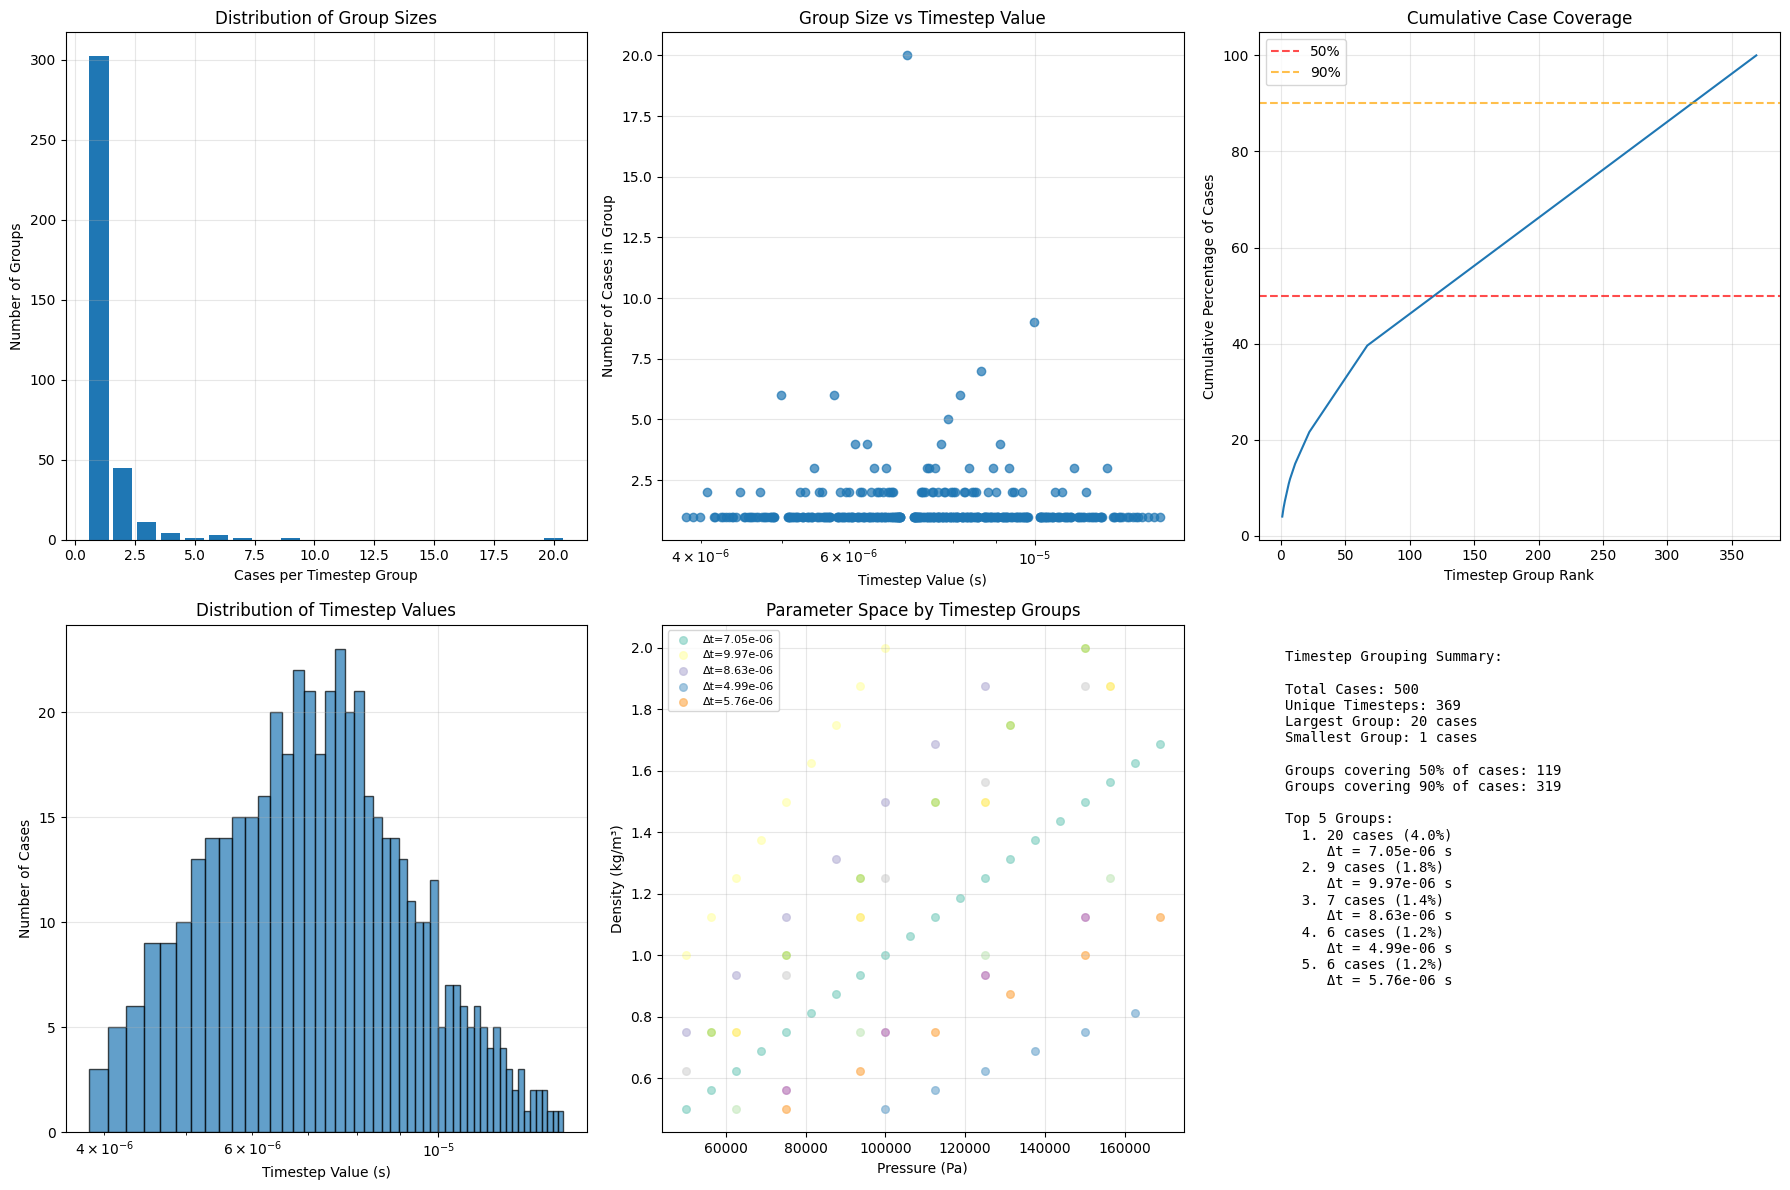


Copying Group 1: Δt = 7.049971e-06, 20 cases
  Copying /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases/p_L_100000/rho_L_1.0 -> /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/largest_group_cases/group_1_dt_7.049971e-06/p_L_100000/rho_L_1.0
  Copying /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases/p_L_106250/rho_L_1.0625 -> /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/largest_group_cases/group_1_dt_7.049971e-06/p_L_106250/rho_L_1.0625
  Copying /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases/p_L_112500/rho_L_1.125 -> /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/largest_group_cases/group_1_dt_7.049971e-06/p_L_112500/rho_L_1.125
  Copying /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases/p_L_118750/

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import json
from collections import defaultdict, Counter
import shutil

class TimestepGroupingAnalyzer:
    """
    Analyze how many cases can be grouped by the same timestep values.
    """
    
    def __init__(self, base_data_dir):
        self.base_data_dir = Path(base_data_dir)
        self.timestep_data = {}
        self.timestep_groups = {}
        
    def extract_timestep_from_filename(self, filename):
        """Extract timestep number from filename pattern."""
        match = re.search(r'\.plot\.(\d+)\.2d\.hdf5', str(filename))
        return int(match.group(1)) if match else None
    
    def extract_timestep_from_hdf5(self, hdf5_file):
        """Extract timestep information from HDF5 file."""
        timestep_info = {}
        
        try:
            with h5py.File(hdf5_file, 'r') as f:
                # Common locations for timestep data
                possible_time_locations = [
                    'time', 'TIME', 'current_time', 'simulation_time', 'Time',
                    'dt', 'timestep', 'delta_t', 'time_step'
                ]
                
                # Check root attributes first
                for attr_name in possible_time_locations:
                    if attr_name in f.attrs:
                        timestep_info[f'attr_{attr_name}'] = float(f.attrs[attr_name])
                
                # Check for time datasets
                for time_name in possible_time_locations:
                    if time_name in f:
                        time_data = f[time_name]
                        if isinstance(time_data, h5py.Dataset):
                            timestep_info[f'dataset_{time_name}'] = float(time_data[()])
                
                # Check level_0 group
                if 'level_0' in f:
                    level_group = f['level_0']
                    for attr_name in possible_time_locations:
                        if attr_name in level_group.attrs:
                            timestep_info[f'level0_attr_{attr_name}'] = float(level_group.attrs[attr_name])
                
                # Extract filename-based timestep
                filename_timestep = self.extract_timestep_from_filename(hdf5_file.name)
                if filename_timestep is not None:
                    timestep_info['filename_timestep'] = filename_timestep
                    
        except Exception as e:
            print(f"Error reading {hdf5_file}: {e}")
            
        return timestep_info
    
    def get_case_files(self, case_dir):
        """Get sorted list of HDF5 files for a case."""
        files = list(case_dir.glob('*.plot.*.2d.hdf5'))
        return sorted(files, key=lambda f: self.extract_timestep_from_filename(f.name) or 0)
    
    def analyze_case_timesteps(self, case_dir, case_name):
        """Analyze timestep information for a single case."""
        files = self.get_case_files(case_dir)
        if len(files) < 2:
            return None
        
        case_timestep_data = []
        for i, file_path in enumerate(files):
            timestep_info = self.extract_timestep_from_hdf5(file_path)
            timestep_info['file_index'] = i
            timestep_info['filename'] = file_path.name
            case_timestep_data.append(timestep_info)
        
        # Extract time values and compute delta t
        time_values = []
        for data in case_timestep_data:
            time_value = None
            for key in data:
                if 'time' in key.lower() and 'step' not in key.lower():
                    time_value = data[key]
                    break
            if time_value is not None:
                time_values.append(time_value)
        
        if len(time_values) > 1:
            time_diffs = np.diff(time_values)
            mean_dt = float(np.mean(time_diffs))
            std_dt = float(np.std(time_diffs))
            
            return {
                'mean_dt': mean_dt,
                'std_dt': std_dt,
                'dt_values': time_diffs.tolist(),
                'is_constant_dt': std_dt < 1e-12,  # Nearly constant
                'total_files': len(files),
                'time_range': [float(time_values[0]), float(time_values[-1])]
            }
        
        return None
    
    def discover_and_analyze_all_cases(self):
        """Discover and analyze timestep information for all cases."""
        print(f"Discovering cases in: {self.base_data_dir}")
        
        pressure_dirs = sorted([d for d in self.base_data_dir.iterdir() 
                               if d.is_dir() and d.name.startswith('p_L_')])
        
        all_results = {}
        
        for p_dir in pressure_dirs:
            pressure_val = p_dir.name
            density_dirs = sorted([d for d in p_dir.iterdir() 
                                 if d.is_dir() and d.name.startswith('rho_L_')])
            
            for rho_dir in density_dirs:
                density_val = rho_dir.name
                plot_dir = rho_dir / 'plot'
                
                if plot_dir.exists() and plot_dir.is_dir():
                    hdf5_files = list(plot_dir.glob('*.plot.*.2d.hdf5'))
                    if hdf5_files:
                        case_name = f"{pressure_val}_{density_val}"
                        
                        # Extract parameter values
                        pressure_match = re.search(r'p_L_(\d+)', pressure_val)
                        density_match = re.search(r'rho_L_([\d.]+)', density_val)
                        
                        pressure_numeric = float(pressure_match.group(1)) if pressure_match else None
                        density_numeric = float(density_match.group(1)) if density_match else None
                        
                        case_result = self.analyze_case_timesteps(plot_dir, case_name)
                        
                        if case_result:
                            case_result['parameters'] = {
                                'pressure_str': pressure_val,
                                'density_str': density_val,
                                'pressure_numeric': pressure_numeric,
                                'density_numeric': density_numeric
                            }
                            all_results[case_name] = case_result
        
        self.timestep_data = all_results
        return all_results
    
    def group_cases_by_timestep(self, results, tolerance=1e-8):
        """Group cases by their mean timestep values with specified tolerance."""
        
        # Extract timestep values
        timestep_to_cases = defaultdict(list)
        
        for case_name, case_data in results.items():
            if 'mean_dt' in case_data:
                mean_dt = case_data['mean_dt']
                
                # Find if this timestep already exists within tolerance
                matched_dt = None
                for existing_dt in timestep_to_cases.keys():
                    if abs(existing_dt - mean_dt) / existing_dt < tolerance:
                        matched_dt = existing_dt
                        break
                
                if matched_dt is not None:
                    timestep_to_cases[matched_dt].append((case_name, case_data))
                else:
                    timestep_to_cases[mean_dt].append((case_name, case_data))
        
        # Convert to regular dict and sort by timestep value
        grouped_results = {}
        for dt in sorted(timestep_to_cases.keys()):
            grouped_results[dt] = timestep_to_cases[dt]
        
        self.timestep_groups = grouped_results
        return grouped_results
    
    def analyze_timestep_groups(self, grouped_results):
        """Analyze the grouped timestep results."""
        
        print("\n" + "="*80)
        print("TIMESTEP GROUPING ANALYSIS")
        print("="*80)
        
        total_cases = sum(len(cases) for cases in grouped_results.values())
        num_unique_timesteps = len(grouped_results)
        
        print(f"Total cases analyzed: {total_cases}")
        print(f"Number of unique timestep values: {num_unique_timesteps}")
        print(f"Average cases per timestep: {total_cases/num_unique_timesteps:.1f}")
        
        # Sort groups by size (number of cases)
        groups_by_size = sorted(grouped_results.items(), 
                               key=lambda x: len(x[1]), reverse=True)
        
        print(f"\nTimestep groups (sorted by number of cases):")
        print(f"{'Rank':<5} {'Timestep (s)':<15} {'Cases':<8} {'Percentage':<12} {'Sample Cases'}")
        print("-" * 80)
        
        for rank, (dt, cases) in enumerate(groups_by_size, 1):
            percentage = len(cases) / total_cases * 100
            sample_cases = [case_name for case_name, _ in cases[:3]]  # First 3 cases
            sample_str = ", ".join(sample_cases)
            if len(cases) > 3:
                sample_str += f", ... (+{len(cases)-3} more)"
            
            print(f"{rank:<5} {dt:.6e}      {len(cases):<8} {percentage:.1f}%         {sample_str}")
        
        # Analyze parameter patterns within groups
        print(f"\nParameter analysis for largest groups:")
        print("-" * 50)
        
        for rank, (dt, cases) in enumerate(groups_by_size[:5], 1):  # Top 5 groups
            print(f"\nGroup {rank}: Δt = {dt:.6e} s ({len(cases)} cases)")
            
            # Extract parameter values
            pressures = []
            densities = []
            for case_name, case_data in cases:
                params = case_data['parameters']
                if params['pressure_numeric'] and params['density_numeric']:
                    pressures.append(params['pressure_numeric'])
                    densities.append(params['density_numeric'])
            
            if pressures and densities:
                print(f"  Pressure range: {min(pressures):.0f} - {max(pressures):.0f} Pa")
                print(f"  Density range: {min(densities):.1f} - {max(densities):.1f} kg/m³")
                print(f"  Unique pressures: {len(set(pressures))}")
                print(f"  Unique densities: {len(set(densities))}")
        
        return {
            'total_cases': total_cases,
            'unique_timesteps': num_unique_timesteps,
            'groups_by_size': groups_by_size,
            'largest_group_size': len(groups_by_size[0][1]) if groups_by_size else 0,
            'smallest_group_size': len(groups_by_size[-1][1]) if groups_by_size else 0
        }
    
    def create_grouping_visualizations(self, grouped_results, analysis_stats):
        """Create visualizations for timestep grouping analysis."""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Group size distribution
        group_sizes = [len(cases) for cases in grouped_results.values()]
        size_counts = Counter(group_sizes)
        
        axes[0,0].bar(size_counts.keys(), size_counts.values())
        axes[0,0].set_xlabel('Cases per Timestep Group')
        axes[0,0].set_ylabel('Number of Groups')
        axes[0,0].set_title('Distribution of Group Sizes')
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Timestep values vs group size
        timesteps = list(grouped_results.keys())
        group_sizes = [len(cases) for cases in grouped_results.values()]
        
        axes[0,1].scatter(timesteps, group_sizes, alpha=0.7)
        axes[0,1].set_xlabel('Timestep Value (s)')
        axes[0,1].set_ylabel('Number of Cases in Group')
        axes[0,1].set_title('Group Size vs Timestep Value')
        axes[0,1].set_xscale('log')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Cumulative cases vs timestep rank
        groups_by_size = sorted(grouped_results.items(), 
                               key=lambda x: len(x[1]), reverse=True)
        
        cumulative_cases = np.cumsum([len(cases) for _, cases in groups_by_size])
        total_cases = cumulative_cases[-1]
        cumulative_percentage = cumulative_cases / total_cases * 100
        
        axes[0,2].plot(range(1, len(groups_by_size) + 1), cumulative_percentage)
        axes[0,2].set_xlabel('Timestep Group Rank')
        axes[0,2].set_ylabel('Cumulative Percentage of Cases')
        axes[0,2].set_title('Cumulative Case Coverage')
        axes[0,2].grid(True, alpha=0.3)
        axes[0,2].axhline(y=50, color='r', linestyle='--', alpha=0.7, label='50%')
        axes[0,2].axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90%')
        axes[0,2].legend()
        
        # 4. Timestep histogram
        all_timesteps = []
        for dt, cases in grouped_results.items():
            all_timesteps.extend([dt] * len(cases))
        
        axes[1,0].hist(all_timesteps, bins=50, alpha=0.7, edgecolor='black')
        axes[1,0].set_xlabel('Timestep Value (s)')
        axes[1,0].set_ylabel('Number of Cases')
        axes[1,0].set_title('Distribution of Timestep Values')
        axes[1,0].set_xscale('log')
        axes[1,0].grid(True, alpha=0.3)
        
        # 5. Parameter space coverage for largest groups
        colors = plt.cm.Set3(np.linspace(0, 1, min(10, len(groups_by_size))))
        
        for i, (dt, cases) in enumerate(groups_by_size[:10]):  # Top 10 groups
            pressures = []
            densities = []
            for case_name, case_data in cases:
                params = case_data['parameters']
                if params['pressure_numeric'] and params['density_numeric']:
                    pressures.append(params['pressure_numeric'])
                    densities.append(params['density_numeric'])
            
            if pressures and densities:
                axes[1,1].scatter(pressures, densities, alpha=0.7, 
                                 color=colors[i], s=30, 
                                 label=f'Δt={dt:.2e}' if i < 5 else '')
        
        axes[1,1].set_xlabel('Pressure (Pa)')
        axes[1,1].set_ylabel('Density (kg/m³)')
        axes[1,1].set_title('Parameter Space by Timestep Groups')
        axes[1,1].legend(fontsize=8)
        axes[1,1].grid(True, alpha=0.3)
        
        # 6. Summary statistics
        axes[1,2].axis('off')
        
        stats_text = "Timestep Grouping Summary:\n\n"
        stats_text += f"Total Cases: {analysis_stats['total_cases']}\n"
        stats_text += f"Unique Timesteps: {analysis_stats['unique_timesteps']}\n"
        stats_text += f"Largest Group: {analysis_stats['largest_group_size']} cases\n"
        stats_text += f"Smallest Group: {analysis_stats['smallest_group_size']} cases\n\n"
        
        # Find how many groups contain 50% and 90% of cases
        cases_50pct = total_cases * 0.5
        cases_90pct = total_cases * 0.9
        
        groups_for_50pct = next(i for i, cum in enumerate(cumulative_cases, 1) 
                               if cum >= cases_50pct)
        groups_for_90pct = next(i for i, cum in enumerate(cumulative_cases, 1) 
                               if cum >= cases_90pct)
        
        stats_text += f"Groups covering 50% of cases: {groups_for_50pct}\n"
        stats_text += f"Groups covering 90% of cases: {groups_for_90pct}\n\n"
        
        stats_text += "Top 5 Groups:\n"
        for i, (dt, cases) in enumerate(groups_by_size[:5], 1):
            percentage = len(cases) / total_cases * 100
            stats_text += f"  {i}. {len(cases)} cases ({percentage:.1f}%)\n"
            stats_text += f"     Δt = {dt:.2e} s\n"
        
        axes[1,2].text(0.05, 0.95, stats_text, transform=axes[1,2].transAxes, 
                      verticalalignment='top', fontsize=10, fontfamily='monospace')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
def copy_largest_group_cases(grouped_results, base_data_dir, output_dir, top_n=1):
    """
    Copy case directories from the largest timestep groups into a new directory,
    preserving the nested pressure/density folder structure.
    """
    base_data_dir = Path(base_data_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Sort groups by size (largest first)
    groups_by_size = sorted(grouped_results.items(),
                            key=lambda x: len(x[1]), reverse=True)
    
    for group_idx, (dt, cases) in enumerate(groups_by_size[:top_n], 1):
        print(f"\nCopying Group {group_idx}: Δt = {dt:.6e}, {len(cases)} cases")
        
        group_dir = output_dir / f"group_{group_idx}_dt_{dt:.6e}"
        group_dir.mkdir(parents=True, exist_ok=True)
        
        for case_name, case_data in cases:
            # Preserve nested structure: pressure/ρ
            params = case_data['parameters']
            case_path = base_data_dir / params['pressure_str'] / params['density_str']
            dest_path = group_dir / params['pressure_str'] / params['density_str']
            
            if case_path.exists():
                print(f"  Copying {case_path} -> {dest_path}")
                shutil.copytree(case_path, dest_path, dirs_exist_ok=True)
            else:
                print(f"  WARNING: case path not found: {case_path}")



def main():
    """Main execution function for timestep grouping analysis."""
    BASE_DATA_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases"
    
    print("Analyzing Timestep Groupings in HDF5 Shock Tube Data")
    print("=" * 60)
    
    analyzer = TimestepGroupingAnalyzer(BASE_DATA_DIR)
    
    # Analyze all cases
    print("Extracting timestep data from all cases...")
    results = analyzer.discover_and_analyze_all_cases()
    
    if not results:
        print("No timestep data extracted!")
        return
    
    # Group cases by timestep
    print("Grouping cases by timestep values...")
    grouped_results = analyzer.group_cases_by_timestep(results, tolerance=1e-8)
    
    # Analyze the groups
    analysis_stats = analyzer.analyze_timestep_groups(grouped_results)
    
    # Create visualizations
    analyzer.create_grouping_visualizations(grouped_results, analysis_stats)
    
    # Save detailed results
    output_data = {
        'analysis_summary': analysis_stats,
        'grouped_results': {
            str(dt): [(case_name, case_data) for case_name, case_data in cases]
            for dt, cases in grouped_results.items()
        }
    }
    
    json_file = Path(BASE_DATA_DIR).parent / 'timestep_grouping_analysis.json'
    with open(json_file, 'w') as f:
        json.dump(output_data, f, indent=2, default=str)
        
    output_dir = Path(BASE_DATA_DIR).parent / "largest_group_cases"
    copy_largest_group_cases(grouped_results, BASE_DATA_DIR, output_dir, top_n=1)

    
    print(f"\nDetailed grouping results saved to: {json_file}")

if __name__ == "__main__":
    main()

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import imageio
import io
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import json
from datetime import datetime
import os
from collections import defaultdict

class ShockTubeBatchProcessor:
    """
    Enhanced version to process hierarchical shock tube cases, save each simulation separately,
    and analyze variable ranges before train/test/val split.
    Directory structure: cases/p_L_*/rho_L_*/plot/*.hdf5
    """
    
    def __init__(self, base_data_dir):
        self.base_data_dir = Path(base_data_dir)
        self.grid_size = 64  # 64x64 grid as specified
        self.width = 64
        self.height = 64
        # Confirmed variable names for shock tube simulations
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'total_energy']
        
        # For tracking processed cases
        self.case_info = {}
        self.all_variable_stats = {}
        
    def discover_cases(self):
        """Discover all available shock tube cases in the hierarchical directory structure."""
        print(f"🔍 Discovering cases in: {self.base_data_dir}")
        
        if not self.base_data_dir.exists():
            print(f"❌ Directory {self.base_data_dir} does not exist!")
            return []
        
        case_dirs = []
        
        # Navigate through the hierarchical structure: p_L_* / rho_L_* / plot /
        pressure_dirs = sorted([d for d in self.base_data_dir.iterdir() 
                               if d.is_dir() and d.name.startswith('p_L_')])
        
        print(f"  Found {len(pressure_dirs)} pressure directories")
        
        for p_dir in pressure_dirs:
            pressure_val = p_dir.name  # e.g., "p_L_125000"
            
            # Look for density directories inside each pressure directory
            density_dirs = sorted([d for d in p_dir.iterdir() 
                                 if d.is_dir() and d.name.startswith('rho_L_')])
            
            print(f"    {pressure_val}: {len(density_dirs)} density directories")
            
            for rho_dir in density_dirs:
                density_val = rho_dir.name  # e.g., "rho_L_1.75"
                
                # Look for plot directory
                plot_dir = rho_dir / 'plot'
                if plot_dir.exists() and plot_dir.is_dir():
                    # Check if there are HDF5 files in the plot directory
                    hdf5_files = list(plot_dir.glob('*.plot.*.2d.hdf5'))
                    if hdf5_files:
                        case_name = f"{pressure_val}_{density_val}"
                        case_dirs.append((plot_dir, case_name, pressure_val, density_val))
                        print(f"      ✅ {case_name}: {len(hdf5_files)} HDF5 files")
                    else:
                        print(f"      ❌ {pressure_val}_{density_val}: No HDF5 files in plot directory")
                else:
                    print(f"      ❌ {pressure_val}_{density_val}: No plot directory found")
        
        if not case_dirs:
            print("❌ No valid cases with HDF5 files found!")
        else:
            print(f"✅ Total valid cases discovered: {len(case_dirs)}")
            
        return case_dirs

    def get_timestep_files(self, case_dir, pattern="*.plot.*.2d.hdf5"):
        """Get a sorted list of timestep files for a specific case."""
        files = [f for f in case_dir.glob(pattern) if '.map.' not in f.name]
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        return sorted(files, key=extract_timestep)

    def parse_case_parameters(self, case_name, pressure_val, density_val):
        """Extract numerical parameter values from directory names."""
        # Extract pressure value (e.g., "p_L_125000" -> 125000)
        pressure_match = re.search(r'p_L_(\d+)', pressure_val)
        pressure_numeric = float(pressure_match.group(1)) if pressure_match else None
        
        # Extract density value (e.g., "rho_L_1.75" -> 1.75)
        density_match = re.search(r'rho_L_([\d.]+)', density_val)
        density_numeric = float(density_match.group(1)) if density_match else None
        
        return {
            'pressure_str': pressure_val,
            'density_str': density_val,
            'pressure_numeric': pressure_numeric,
            'density_numeric': density_numeric,
            'case_name': case_name
        }

    def read_chombo_data(self, filename):
        """Read and reconstruct 2D grid data from Chombo HDF5 format."""
        with h5py.File(filename, 'r') as f:
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            n_vars = len(offsets) - 1

            if len(self.var_names) != n_vars:
                print(f"Warning: Expected {len(self.var_names)} variables but file contains {n_vars}.")
                var_names = [f'var_{i}' for i in range(n_vars)]
            else:
                var_names = self.var_names
            
            grids = {name: np.zeros((self.grid_size, self.grid_size)) for name in var_names}
            
            data_idx = 0
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                box_data = data_flat[data_idx:data_idx + box_size * n_vars]
                data_idx += box_size * n_vars
                for var_idx, name in enumerate(var_names):
                    var_data = box_data[var_idx * box_size:(var_idx + 1) * box_size]
                    var_data_2d = var_data.reshape((nj, ni))
                    grids[name][box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = var_data_2d
            
            return grids, var_names, boxes

    def _create_graph_connectivity(self):
        """Helper to create the edge_index for a 2D grid graph."""
        num_nodes = self.width * self.height
        nodes = np.arange(num_nodes).reshape(self.height, self.width)
        edges = []

        # Horizontal connections
        for i in range(self.height):
            for j in range(self.width - 1):
                edges.append([nodes[i, j], nodes[i, j+1]])
                edges.append([nodes[i, j+1], nodes[i, j]])

        # Vertical connections
        for i in range(self.height - 1):
            for j in range(self.width):
                edges.append([nodes[i, j], nodes[i+1, j]])
                edges.append([nodes[i+1, j], nodes[i, j]])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        return edge_index

    def analyze_variable_ranges_single_case(self, case_dir, case_name):
        """Analyze variable ranges for a single case."""
        files = self.get_timestep_files(case_dir)
        if not files:
            print(f"    Warning: No files found for case {case_name}")
            return None
        
        print(f"  Analyzing variable ranges for {case_name}...")
        
        case_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                           'all_values': []} for var in self.var_names}
        
        valid_files_count = 0
        
        for file in files:
            try:
                grids, _, _ = self.read_chombo_data(file)
                valid_files_count += 1
                
                for var in self.var_names:
                    if var in grids:
                        data = grids[var]
                        # Filter out invalid values
                        valid_data = data[np.isfinite(data)]
                        if len(valid_data) > 0:
                            case_stats[var]['min'] = min(case_stats[var]['min'], valid_data.min())
                            case_stats[var]['max'] = max(case_stats[var]['max'], valid_data.max())
                            case_stats[var]['all_values'].extend(valid_data.flatten())
                        
            except Exception as e:
                print(f"    Warning: Could not read {file}: {e}")
                continue
        
        if valid_files_count == 0:
            print(f"    Warning: No valid files could be read for case {case_name}")
            return None
        
        # Compute additional statistics
        final_stats = {}
        for var in self.var_names:
            if case_stats[var]['all_values'] and case_stats[var]['min'] != float('inf'):
                values = np.array(case_stats[var]['all_values'])
                final_stats[var] = {
                    'min': float(case_stats[var]['min']),
                    'max': float(case_stats[var]['max']),
                    'mean': float(values.mean()),
                    'std': float(values.std()),
                    'median': float(np.median(values)),
                    'q25': float(np.percentile(values, 25)),
                    'q75': float(np.percentile(values, 75))
                }
            else:
                print(f"    Warning: No valid data found for variable {var} in case {case_name}")
        
        return final_stats if final_stats else None

    def process_single_case(self, case_dir, case_name, pressure_val, density_val, output_path):
        """Process a single shock tube case into PyG format and save separately."""
        print(f"\n📁 Processing case: {case_name}")
        print(f"    Directory: {case_dir}")
        
        files = self.get_timestep_files(case_dir)
        if len(files) < 2:
            print(f"❌ Case {case_name} has insufficient files ({len(files)}). Skipping.")
            return None

        print(f"  Found {len(files)} timestep files")
        
        # Parse case parameters
        case_params = self.parse_case_parameters(case_name, pressure_val, density_val)
        
        # Analyze variable ranges for this case
        case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name)
        
        pyg_data_list = []
        edge_index = self._create_graph_connectivity()
        
        # Create normalized position grid
        x_coords = torch.arange(self.width, dtype=torch.float) / (self.width - 1)
        y_coords = torch.arange(self.height, dtype=torch.float) / (self.height - 1)
        pos_grid = torch.stack(torch.meshgrid(x_coords, y_coords, indexing='xy'), dim=-1)
        pos = pos_grid.reshape(-1, 2)  # Shape: [N, 2]

        # Process consecutive timestep pairs
        valid_pairs = 0
        for i in range(len(files) - 1):
            current_file = files[i]
            next_file = files[i+1]
            
            try:
                # Read data for current and next timestep
                grids_current, _, _ = self.read_chombo_data(current_file)
                grids_next, _, _ = self.read_chombo_data(next_file)

                # Stack physics features: (H, W, C) -> (N, C)
                physics_features = np.stack([grids_current[name] for name in self.var_names], axis=-1)
                physics_features = physics_features.reshape(-1, len(self.var_names))  # [N, 4]
                
                # Stack target features
                target_features = np.stack([grids_next[name] for name in self.var_names], axis=-1)
                target_features = target_features.reshape(-1, len(self.var_names))  # [N, 4]
                
                # Combine positions with physics features
                # Layout: [x_pos, y_pos, density, x_momentum, y_momentum, total_energy]
                combined_features = np.concatenate([pos.numpy(), physics_features], axis=1)  # [N, 6]
                x = torch.tensor(combined_features, dtype=torch.float)
                y = torch.tensor(target_features, dtype=torch.float)  # [N, 4]
                
                # Create PyG Data object with comprehensive metadata
                data_object = Data(
                    x=x, 
                    edge_index=edge_index, 
                    pos=pos, 
                    y=y,
                    case_name=case_name,
                    pressure_str=pressure_val,
                    density_str=density_val,
                    pressure_numeric=case_params['pressure_numeric'],
                    density_numeric=case_params['density_numeric'],
                    timestep_current=i,
                    timestep_next=i+1
                )
                
                pyg_data_list.append(data_object)
                valid_pairs += 1
                
            except Exception as e:
                print(f"    ⚠️  Error processing timestep {i}->{i+1}: {e}")
                continue
        
        print(f"  ✅ Successfully processed {valid_pairs} timestep pairs")
        
        if pyg_data_list:
            # Save this case separately
            case_filename = f"{case_name}_with_pos.pt"
            case_filepath = output_path / "individual_cases" / case_filename
            case_filepath.parent.mkdir(exist_ok=True)
            torch.save(pyg_data_list, case_filepath)
            print(f"  💾 Saved individual case: {case_filepath}")
        
        # Store case information including variable statistics
        self.case_info[case_name] = {
            'total_files': len(files),
            'processed_pairs': len(pyg_data_list),
            'directory': str(case_dir),
            'parameters': case_params,
            'variable_statistics': case_var_stats,
            'saved_file': str(case_filepath) if pyg_data_list else None
        }
        
        return pyg_data_list

    def analyze_global_variable_ranges(self, case_info_list):
        """Analyze variable ranges across all cases before processing."""
        print("\n" + "="*80)
        print("📊 ANALYZING VARIABLE RANGES ACROSS ALL CASES")
        print("="*80)
        
        global_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                             'case_mins': [], 'case_maxs': [], 'case_means': []} 
                       for var in self.var_names}
        
        case_stats_summary = {}
        processed_cases = 0
        
        for case_dir, case_name, pressure_val, density_val in case_info_list:
            case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name)
            
            if case_var_stats is not None and case_var_stats:  # Check for both None and empty dict
                case_stats_summary[case_name] = case_var_stats
                processed_cases += 1
                
                for var in self.var_names:
                    if var in case_var_stats and 'mean' in case_var_stats[var]:
                        stats = case_var_stats[var]
                        global_stats[var]['min'] = min(global_stats[var]['min'], stats['min'])
                        global_stats[var]['max'] = max(global_stats[var]['max'], stats['max'])
                        global_stats[var]['case_mins'].append(stats['min'])
                        global_stats[var]['case_maxs'].append(stats['max'])
                        global_stats[var]['case_means'].append(stats['mean'])
                    else:
                        print(f"    Warning: Missing statistics for variable {var} in case {case_name}")
            else:
                print(f"    Warning: Could not analyze case {case_name} - skipping from global statistics")
        
        if processed_cases == 0:
            print("❌ No cases could be analyzed for variable ranges!")
            return None, None
        
        # Compute global statistics
        for var in self.var_names:
            if global_stats[var]['case_means']:
                global_stats[var]['global_mean_of_means'] = np.mean(global_stats[var]['case_means'])
                global_stats[var]['std_of_means'] = np.std(global_stats[var]['case_means'])
                global_stats[var]['range'] = global_stats[var]['max'] - global_stats[var]['min']
            else:
                print(f"    Warning: No valid data for variable {var} across all cases")
        
        print(f"\n🌐 GLOBAL VARIABLE STATISTICS SUMMARY (from {processed_cases} cases):")
        print("="*60)
        for var in self.var_names:
            stats = global_stats[var]
            if stats['case_means']:
                print(f"\n{var.upper()}:")
                print(f"  Global Range: [{stats['min']:.6e}, {stats['max']:.6e}]")
                print(f"  Range Span: {stats['range']:.6e}")
                print(f"  Mean across cases: {stats['global_mean_of_means']:.6e} ± {stats['std_of_means']:.6e}")
                print(f"  Min values across cases: [{min(stats['case_mins']):.6e}, {max(stats['case_mins']):.6e}]")
                print(f"  Max values across cases: [{min(stats['case_maxs']):.6e}, {max(stats['case_maxs']):.6e}]")
            else:
                print(f"\n{var.upper()}: No valid data found")
        
        print(f"\n📋 PER-CASE VARIABLE STATISTICS:")
        print("="*60)
        for case_name, case_stats in case_stats_summary.items():
            print(f"\n{case_name}:")
            for var in self.var_names:
                if var in case_stats:
                    stats = case_stats[var]
                    print(f"  {var}: [{stats['min']:.4e}, {stats['max']:.4e}] mean={stats['mean']:.4e}")
                else:
                    print(f"  {var}: No valid data")
        
        self.all_variable_stats = {
            'global_statistics': global_stats,
            'case_statistics': case_stats_summary
        }
        
        return global_stats, case_stats_summary

    def process_all_cases(self, output_dir="processed_datasets"):
        """Process all discovered cases and save individually, then analyze before splitting."""
        print("\n" + "="*80)
        print("🚀 BATCH PROCESSING ALL SHOCK TUBE CASES")
        print("="*80)
        
        case_info_list = self.discover_cases()
        if not case_info_list:
            print("❌ No cases found to process!")
            return None
        
        # First, analyze variable ranges across all cases
        global_stats, case_stats = self.analyze_global_variable_ranges(case_info_list)
        
        if global_stats is None:
            print("❌ Variable range analysis failed!")
            return None
        
        # Create output directory
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        (output_path / "individual_cases").mkdir(exist_ok=True)
        
        all_data = []
        case_sample_counts = {}
        parameter_ranges = {'pressure': [], 'density': []}
        
        print(f"\n🔄 PROCESSING INDIVIDUAL CASES:")
        print("="*60)
        
        # Process each case
        for case_dir, case_name, pressure_val, density_val in case_info_list:
            case_data = self.process_single_case(case_dir, case_name, pressure_val, density_val, output_path)
            
            if case_data:
                all_data.extend(case_data)
                case_sample_counts[case_name] = len(case_data)
                
                # Track parameter ranges
                case_params = self.parse_case_parameters(case_name, pressure_val, density_val)
                if case_params['pressure_numeric'] is not None:
                    parameter_ranges['pressure'].append(case_params['pressure_numeric'])
                if case_params['density_numeric'] is not None:
                    parameter_ranges['density'].append(case_params['density_numeric'])
            else:
                print(f"❌ No data processed for case: {case_name}")
        
        if not all_data:
            print("❌ No data was successfully processed!")
            return None
        
        # Calculate parameter statistics
        pressure_stats = {
            'min': min(parameter_ranges['pressure']) if parameter_ranges['pressure'] else None,
            'max': max(parameter_ranges['pressure']) if parameter_ranges['pressure'] else None,
            'unique_values': sorted(list(set(parameter_ranges['pressure']))) if parameter_ranges['pressure'] else []
        }
        density_stats = {
            'min': min(parameter_ranges['density']) if parameter_ranges['density'] else None,
            'max': max(parameter_ranges['density']) if parameter_ranges['density'] else None,
            'unique_values': sorted(list(set(parameter_ranges['density']))) if parameter_ranges['density'] else []
        }
        
        print(f"\n📊 PROCESSING SUMMARY:")
        print("="*60)
        print(f"  Total cases processed: {len(case_sample_counts)}")
        print(f"  Total samples: {len(all_data)}")
        print(f"  Pressure range: {pressure_stats['min']} - {pressure_stats['max']} ({len(pressure_stats['unique_values'])} unique values)")
        print(f"  Density range: {density_stats['min']} - {density_stats['max']} ({len(density_stats['unique_values'])} unique values)")
        print(f"\n  Samples per case:")
        for case_name, count in sorted(case_sample_counts.items()):
            print(f"    {case_name}: {count} samples")
        
        # Save comprehensive metadata
        metadata = {
            'timestamp': datetime.now().isoformat(),
            'total_samples': len(all_data),
            'total_cases': len(case_sample_counts),
            'case_info': self.case_info,
            'case_sample_counts': case_sample_counts,
            'parameter_statistics': {
                'pressure': pressure_stats,
                'density': density_stats
            },
            'variable_statistics': self.all_variable_stats,
            'feature_layout': '[x_pos, y_pos, density, x_momentum, y_momentum, total_energy]',
            'target_layout': '[density, x_momentum, y_momentum, total_energy]',
            'grid_size': f'{self.grid_size}x{self.grid_size}',
            'domain_size': '0.5x0.5 meters',
            'pressure_ratio': '10:1 (left:right)',
            'density_ratio': '8:1 (left:right)',
            'physics_model': 'Compressible Euler equations',
            'directory_structure': 'cases/p_L_*/rho_L_*/plot/*.hdf5'
        }
        
        with open(output_path / 'dataset_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Also save just the variable statistics for easy access
        with open(output_path / 'variable_statistics.json', 'w') as f:
            json.dump(self.all_variable_stats, f, indent=2)
        
        return all_data, output_path

    def create_train_test_val_split(self, all_data, output_path, 
                                  train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                  random_state=42, split_by_parameter_ranges=True):
        """
        Create train/test/validation splits by parameter ranges for extrapolation/interpolation testing.
        This ensures proper physics generalization testing with unseen parameter combinations.
        """
        print(f"\n📊 CREATING TRAIN/TEST/VAL SPLIT BY PARAMETER RANGES")
        print(f"  Ratios - Train: {train_ratio}, Val: {val_ratio}, Test: {test_ratio}")
        
        if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
            print(f"❌ Split ratios don't sum to 1.0!")
            return None
        
        # Group data by case name and extract parameter information
        case_groups = {}
        case_params = {}
        for data in all_data:
            case_name = data.case_name if hasattr(data, 'case_name') else 'unknown'
            if case_name not in case_groups:
                case_groups[case_name] = []
            case_groups[case_name].append(data)
            
            # Extract parameter values for splitting logic
            pressure = getattr(data, 'pressure_numeric', 0)
            density = getattr(data, 'density_numeric', 0)
            case_params[case_name] = (pressure, density)
        
        print(f"  Found {len(case_groups)} unique parameter combinations")
        
        if split_by_parameter_ranges:
            # Analyze parameter space
            pressures = sorted(set(p for p, d in case_params.values()))
            densities = sorted(set(d for p, d in case_params.values()))
            
            print(f"\n  Parameter space analysis:")
            print(f"    Pressures: {len(pressures)} unique values")
            print(f"      Range: {min(pressures):.0f} to {max(pressures):.0f}")
            print(f"      Values: {pressures}")
            print(f"    Densities: {len(densities)} unique values") 
            print(f"      Range: {min(densities):.3f} to {max(densities):.3f}")
            print(f"      Values: {densities}")
            
            # Define parameter ranges for train/val/test splits
            # Strategy: Train on middle ranges, test on edges and gaps for extrapolation/interpolation
            
            # Pressure splitting (divide into low/mid/high regions)
            p_low_thresh = np.percentile(pressures, 25)
            p_high_thresh = np.percentile(pressures, 75)
            
            # Density splitting (divide into low/mid/high regions) 
            d_low_thresh = np.percentile(densities, 25)
            d_high_thresh = np.percentile(densities, 75)
            
            print(f"\n  Parameter range thresholds:")
            print(f"    Pressure: Low < {p_low_thresh:.0f} | Mid: {p_low_thresh:.0f}-{p_high_thresh:.0f} | High > {p_high_thresh:.0f}")
            print(f"    Density:  Low < {d_low_thresh:.3f} | Mid: {d_low_thresh:.3f}-{d_high_thresh:.3f} | High > {d_high_thresh:.3f}")
            
            # Categorize cases by parameter regions
            train_cases = []
            val_cases = []
            test_cases = []
            
            for case_name, (pressure, density) in case_params.items():
                # Classify pressure region
                if pressure < p_low_thresh:
                    p_region = 'low'
                elif pressure > p_high_thresh:
                    p_region = 'high'
                else:
                    p_region = 'mid'
                
                # Classify density region
                if density < d_low_thresh:
                    d_region = 'low'
                elif density > d_high_thresh:
                    d_region = 'high'
                else:
                    d_region = 'mid'
                
                region = f"{p_region}_{d_region}"
                
                # Assignment strategy for physics extrapolation/interpolation testing:
                # Train: Core middle regions + some mixed regions
                # Val: Some interpolation cases within training bounds
                # Test: Extrapolation cases (extreme corners) + interpolation gaps
                
                if region in ['mid_mid']:
                    # Core training region - most cases go to train
                    train_cases.append(case_name)
                elif region in ['low_mid', 'high_mid', 'mid_low', 'mid_high']:
                    # Mixed regions - split between train and val for interpolation testing
                    if len(val_cases) < len(case_groups) * val_ratio:
                        val_cases.append(case_name)
                    else:
                        train_cases.append(case_name)
                elif region in ['low_low', 'low_high', 'high_low', 'high_high']:
                    # Extreme corners - test extrapolation
                    test_cases.append(case_name)
                else:
                    # Fallback to train
                    train_cases.append(case_name)
            
            # Balance the splits if needed
            total_cases = len(case_groups)
            target_train = int(total_cases * train_ratio)
            target_val = int(total_cases * val_ratio)
            target_test = int(total_cases * test_ratio)
            
            # Adjust if we have too many/few in any split
            while len(train_cases) < target_train and (len(val_cases) > target_val or len(test_cases) > target_test):
                if len(val_cases) > target_val:
                    case_to_move = val_cases.pop()
                    train_cases.append(case_to_move)
                elif len(test_cases) > target_test:
                    case_to_move = test_cases.pop()
                    train_cases.append(case_to_move)
                else:
                    break
            
            while len(val_cases) < target_val and len(train_cases) > target_train:
                case_to_move = train_cases.pop()
                val_cases.append(case_to_move)
            
            # Assign ALL timesteps from each case to the designated split
            train_data = []
            val_data = []
            test_data = []
            
            print(f"\n  Split assignment by parameter ranges:")
            print(f"    Train cases ({len(train_cases)}) - Core and mixed regions:")
            for case_name in sorted(train_cases):
                case_data = case_groups[case_name]
                train_data.extend(case_data)
                p, d = case_params[case_name]
                p_reg = 'low' if p < p_low_thresh else 'high' if p > p_high_thresh else 'mid'
                d_reg = 'low' if d < d_low_thresh else 'high' if d > d_high_thresh else 'mid'
                print(f"      {case_name}: {len(case_data)} timesteps (p={p:.0f}[{p_reg}], ρ={d:.3f}[{d_reg}])")
            
            print(f"    Val cases ({len(val_cases)}) - Interpolation within training bounds:")
            for case_name in sorted(val_cases):
                case_data = case_groups[case_name]
                val_data.extend(case_data)
                p, d = case_params[case_name]
                p_reg = 'low' if p < p_low_thresh else 'high' if p > p_high_thresh else 'mid'
                d_reg = 'low' if d < d_low_thresh else 'high' if d > d_high_thresh else 'mid'
                print(f"      {case_name}: {len(case_data)} timesteps (p={p:.0f}[{p_reg}], ρ={d:.3f}[{d_reg}])")
            
            print(f"    Test cases ({len(test_cases)}) - Extrapolation to unseen parameter ranges:")
            for case_name in sorted(test_cases):
                case_data = case_groups[case_name]
                test_data.extend(case_data)
                p, d = case_params[case_name]
                p_reg = 'low' if p < p_low_thresh else 'high' if p > p_high_thresh else 'mid'
                d_reg = 'low' if d < d_low_thresh else 'high' if d > d_high_thresh else 'mid'
                print(f"      {case_name}: {len(case_data)} timesteps (p={p:.0f}[{p_reg}], ρ={d:.3f}[{d_reg}])")
            
        else:
            # Fallback: simple random split by cases (not recommended)
            print("  ⚠️  Using simple case-based splitting (not parameter-range based)")
            case_names = list(case_groups.keys())
            train_cases, temp_cases = train_test_split(case_names, test_size=(1-train_ratio), random_state=random_state)
            val_cases, test_cases = train_test_split(temp_cases, test_size=(test_ratio/(val_ratio+test_ratio)), random_state=random_state)
            
            train_data = []
            val_data = []
            test_data = []
            
            for case_name in train_cases:
                train_data.extend(case_groups[case_name])
            for case_name in val_cases:
                val_data.extend(case_groups[case_name])
            for case_name in test_cases:
                test_data.extend(case_groups[case_name])
        
        print(f"\n📈 FINAL SPLIT SIZES:")
        print(f"  Train: {len(train_data)} samples ({len(train_data)/len(all_data)*100:.1f}%)")
        print(f"  Val:   {len(val_data)} samples ({len(val_data)/len(all_data)*100:.1f}%)")
        print(f"  Test:  {len(test_data)} samples ({len(test_data)/len(all_data)*100:.1f}%)")
        
        # Analyze parameter coverage and physics testing capability
        def analyze_parameter_coverage(split_data, split_name):
            split_cases = set(getattr(d, 'case_name', 'unknown') for d in split_data)
            split_pressures = sorted(set(getattr(d, 'pressure_numeric', 0) for d in split_data))
            split_densities = sorted(set(getattr(d, 'density_numeric', 0) for d in split_data))
            
            p_range = f"{min(split_pressures):.0f}-{max(split_pressures):.0f}" if split_pressures else "None"
            d_range = f"{min(split_densities):.3f}-{max(split_densities):.3f}" if split_densities else "None"
            
            print(f"    {split_name}: {len(split_cases)} cases")
            print(f"      Pressure range: {p_range} ({len(split_pressures)} values)")
            print(f"      Density range:  {d_range} ({len(split_densities)} values)")
            
            return split_cases, split_pressures, split_densities
        
        print(f"\n📊 PARAMETER COVERAGE BY SPLIT:")
        train_cases_set, train_p, train_d = analyze_parameter_coverage(train_data, "Train")
        val_cases_set, val_p, val_d = analyze_parameter_coverage(val_data, "Val")
        test_cases_set, test_p, test_d = analyze_parameter_coverage(test_data, "Test")
        
        # Physics generalization analysis
        print(f"\n🔬 PHYSICS GENERALIZATION ANALYSIS:")
        
        # Check for parameter extrapolation in test set
        train_p_min, train_p_max = min(train_p) if train_p else 0, max(train_p) if train_p else 0
        train_d_min, train_d_max = min(train_d) if train_d else 0, max(train_d) if train_d else 0
        
        test_p_extrapolation = [p for p in test_p if p < train_p_min or p > train_p_max]
        test_d_extrapolation = [d for d in test_d if d < train_d_min or d > train_d_max]
        
        print(f"  Training parameter bounds:")
        print(f"    Pressure: [{train_p_min:.0f}, {train_p_max:.0f}]")
        print(f"    Density:  [{train_d_min:.3f}, {train_d_max:.3f}]")
        print(f"  Test extrapolation cases:")
        print(f"    Pressure extrapolation: {len(test_p_extrapolation)} values beyond training range")
        print(f"    Density extrapolation:  {len(test_d_extrapolation)} values beyond training range")
        
        # Check for case overlap (should be zero)
        case_overlap = len(train_cases_set & val_cases_set) + len(train_cases_set & test_cases_set) + len(val_cases_set & test_cases_set)
        if case_overlap == 0:
            print(f"  ✅ No case overlap between splits - proper parameter separation!")
        else:
            print(f"  ⚠️  WARNING: {case_overlap} overlapping cases detected between splits!")
        
        # Save the datasets
        datasets = {
            'train': train_data,
            'val': val_data,
            'test': test_data
        }
        
        saved_files = {}
        for split_name, split_data in datasets.items():
            filename = f"shock_tube_{split_name}_with_pos.pt"
            filepath = output_path / filename
            torch.save(split_data, filepath)
            saved_files[split_name] = str(filepath)
            print(f"💾 Saved {split_name} split: {filepath}")
        
        # Update metadata with comprehensive split information
        split_metadata = {
            'split_method': 'parameter_ranges' if split_by_parameter_ranges else 'random_cases',
            'split_ratios': {'train': train_ratio, 'val': val_ratio, 'test': test_ratio},
            'split_sizes': {
                'train': len(train_data), 
                'val': len(val_data), 
                'test': len(test_data)
            },
            'case_counts': {
                'train': len(train_cases_set),
                'val': len(val_cases_set), 
                'test': len(test_cases_set)
            },
            'parameter_coverage': {
                'train': {
                    'pressures': {'count': len(train_p), 'range': [min(train_p), max(train_p)] if train_p else [0, 0]},
                    'densities': {'count': len(train_d), 'range': [min(train_d), max(train_d)] if train_d else [0, 0]}
                },
                'val': {
                    'pressures': {'count': len(val_p), 'range': [min(val_p), max(val_p)] if val_p else [0, 0]},
                    'densities': {'count': len(val_d), 'range': [min(val_d), max(val_d)] if val_d else [0, 0]}
                },
                'test': {
                    'pressures': {'count': len(test_p), 'range': [min(test_p), max(test_p)] if test_p else [0, 0]},
                    'densities': {'count': len(test_d), 'range': [min(test_d), max(test_d)] if test_d else [0, 0]}
                }
            },
            'extrapolation_analysis': {
                'train_bounds': {
                    'pressure': [train_p_min, train_p_max],
                    'density': [train_d_min, train_d_max]
                },
                'test_extrapolation': {
                    'pressure_values': test_p_extrapolation,
                    'density_values': test_d_extrapolation,
                    'extrapolation_cases': len(set([case for case, (p, d) in case_params.items() 
                                                   if case in test_cases_set and 
                                                   (p < train_p_min or p > train_p_max or d < train_d_min or d > train_d_max)]))
                }
            },
            'physics_testing_type': 'extrapolation_and_interpolation',
            'case_overlap_count': case_overlap,
            'random_state': random_state,
            'saved_files': saved_files
        }
        
        # Load existing metadata and add split info
        metadata_file = output_path / 'dataset_metadata.json'
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        metadata['train_test_val_split'] = split_metadata
        
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"📄 Updated metadata: {metadata_file}")
        
        return datasets

    def split_datasets_by_case(self, base_path):
        """
        Split existing train/test/val files into individual case files.
        
        Args:
            base_path: Path to directory containing the combined .pt files
        """
        base_path = Path(base_path)
        
        # Define the splits to process
        splits = ['train', 'val', 'test']
        
        print(f"\n🔄 SPLITTING EXISTING TRAIN/TEST/VAL FILES BY CASE")
        print("="*60)
        
        for split in splits:
            print(f"\n📂 Processing {split.upper()} split...")
            
            # Load the combined file
            combined_file = base_path / f"shock_tube_{split}_with_pos.pt"
            if not combined_file.exists():
                print(f"❌ File not found: {combined_file}")
                continue
                
            print(f"   Loading: {combined_file}")
            dataset = torch.load(combined_file, weights_only=False)
            print(f"   Total samples: {len(dataset)}")
            
            # Group by case name
            case_groups = defaultdict(list)
            for data in dataset:
                case_name = getattr(data, 'case_name', 'unknown')
                case_groups[case_name].append(data)
            
            print(f"   Found {len(case_groups)} unique cases")
            
            # Create split-specific directory
            split_dir = base_path / f"{split}_cases"
            split_dir.mkdir(exist_ok=True)
            
            # Save each case separately
            case_counts = {}
            for case_name, case_data in case_groups.items():
                case_filename = f"{case_name}_{split}_with_pos.pt"
                case_filepath = split_dir / case_filename
                torch.save(case_data, case_filepath)
                case_counts[case_name] = len(case_data)
                print(f"   💾 {case_name}: {len(case_data)} samples -> {case_filepath}")
            
            # Save case summary for this split
            summary = {
                'split': split,
                'total_samples': len(dataset),
                'total_cases': len(case_groups),
                'case_counts': case_counts,
                'files_saved_to': str(split_dir)
            }
            
            summary_file = split_dir / f"{split}_cases_summary.json"
            with open(summary_file, 'w') as f:
                json.dump(summary, f, indent=2)
            
            print(f"   📄 Summary saved: {summary_file}")
        
        print("\n🎉 CASE SPLITTING COMPLETE!")
        print("\nNew directory structure:")
        print("  📁 train_cases/")
        print("    - p_L_*_rho_L_*_train_with_pos.pt (one per case)")
        print("    - train_cases_summary.json")
        print("  📁 val_cases/")
        print("    - p_L_*_rho_L_*_val_with_pos.pt (one per case)")
        print("    - val_cases_summary.json")
        print("  📁 test_cases/")
        print("    - p_L_*_rho_L_*_test_with_pos.pt (one per case)")
        print("    - test_cases_summary.json")

    def analyze_dataset_statistics(self, dataset, split_name=""):
        """Analyze statistics for a dataset split."""
        if not dataset:
            return
            
        print(f"\n📊 DATASET STATISTICS {split_name}")
        print("-" * 50)
        
        # Sample the first data point for structure analysis
        sample = dataset[0]
        print(f"Sample structure:")
        print(f"  x.shape: {sample.x.shape}")
        print(f"  y.shape: {sample.y.shape}")
        print(f"  edge_index.shape: {sample.edge_index.shape}")
        print(f"  pos.shape: {sample.pos.shape}")
        
        # Case distribution
        case_counts = {}
        pressure_counts = {}
        density_counts = {}
        
        for data in dataset:
            case_name = getattr(data, 'case_name', 'unknown')
            pressure = getattr(data, 'pressure_numeric', None)
            density = getattr(data, 'density_numeric', None)
            
            case_counts[case_name] = case_counts.get(case_name, 0) + 1
            if pressure is not None:
                pressure_counts[pressure] = pressure_counts.get(pressure, 0) + 1
            if density is not None:
                density_counts[density] = density_counts.get(density, 0) + 1
        
        print(f"\nCase distribution:")
        for case_name, count in sorted(case_counts.items()):
            print(f"  {case_name}: {count} samples")
        
        print(f"\nPressure parameter distribution:")
        for pressure, count in sorted(pressure_counts.items()):
            print(f"  p_L_{pressure}: {count} samples")
            
        print(f"\nDensity parameter distribution:")
        for density, count in sorted(density_counts.items()):
            print(f"  rho_L_{density}: {count} samples")


def main():
    """Main execution function."""
    BASE_DATA_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases"
    OUTPUT_DIR = "/project/vil_baek/psaap/processed_cases"
    
    # Initialize processor
    processor = ShockTubeBatchProcessor(BASE_DATA_DIR)
    
    # Process all cases (this will save each simulation separately AND analyze variable ranges)
    result = processor.process_all_cases(output_dir=OUTPUT_DIR)
    
    if result is None:
        print("❌ Processing failed!")
        return
    
    all_data, output_path = result
    
    print(f"\n🤔 READY FOR TRAIN/TEST/VAL SPLIT")
    print("="*80)
    print("📊 Variable range analysis complete - check variable_statistics.json")
    print("📁 Individual simulations saved in individual_cases/ directory")
    print("\nProceed with train/test/val split? (y/n): ", end="")
    
    # For automated execution, comment out the input() and set proceed = True
    proceed = input().lower().strip() in ['y', 'yes', '']
    
    if proceed:
        # Create train/test/val splits (default to initial condition splitting)
        datasets = processor.create_train_test_val_split(
            all_data, 
            output_path,
            train_ratio=0.7,
            val_ratio=0.15, 
            test_ratio=0.15,
            split_by_parameter_ranges=True  # Changed parameter name for clarity
        )
        
        if datasets:
            # Analyze each split
            for split_name, split_data in datasets.items():
                processor.analyze_dataset_statistics(split_data, f"({split_name.upper()})")
            
            print(f"\n🔄 SPLITTING DATASETS BY CASE")
            print("="*60)
            print("Split the combined train/test/val files into individual case files? (y/n): ", end="")
            
            # For automated execution, comment out the input() and set split_by_case = True
            split_by_case = input().lower().strip() in ['y', 'yes', '']
            
            if split_by_case:
                processor.split_datasets_by_case(output_path)
    
    print("\n🎉 BATCH PROCESSING COMPLETE!")
    print(f"📁 All outputs saved to: {output_path}")
    print("\nGenerated files:")
    print("  📊 Analysis files:")
    print("    - dataset_metadata.json (comprehensive metadata)")
    print("    - variable_statistics.json (detailed variable ranges)")
    print("  📁 Individual simulations:")
    print("    - individual_cases/*.pt (each simulation saved separately)")
    print("  🎯 Train/Test/Val splits:")
    print("    - shock_tube_train_with_pos.pt")
    print("    - shock_tube_val_with_pos.pt") 
    print("    - shock_tube_test_with_pos.pt")
    print("  📂 Individual case splits (if created):")
    print("    - train_cases/*.pt")
    print("    - val_cases/*.pt")
    print("    - test_cases/*.pt")


def split_existing_datasets_by_case(base_path):
    """
    Standalone function to split existing train/test/val files into individual case files.
    Can be run independently if you already have the combined files.
    
    Args:
        base_path: Path to directory containing the combined .pt files
    """
    processor = ShockTubeBatchProcessor("")  # Empty base dir since we're not processing raw data
    processor.split_datasets_by_case(base_path)


if __name__ == "__main__":
    main()


🚀 BATCH PROCESSING ALL SHOCK TUBE CASES
🔍 Discovering cases in: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases
  Found 20 pressure directories
    p_L_100000: 25 density directories
      ✅ p_L_100000_rho_L_0.5: 44 HDF5 files
      ✅ p_L_100000_rho_L_0.5625: 44 HDF5 files
      ✅ p_L_100000_rho_L_0.625: 44 HDF5 files
      ✅ p_L_100000_rho_L_0.6875: 44 HDF5 files
      ✅ p_L_100000_rho_L_0.75: 44 HDF5 files
      ✅ p_L_100000_rho_L_0.8125: 44 HDF5 files
      ✅ p_L_100000_rho_L_0.875: 44 HDF5 files
      ✅ p_L_100000_rho_L_0.9375: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.0: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.0625: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.125: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.1875: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.25: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.3125: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.375: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.4375: 44 HDF5 files
      ✅ p_L_100000_rho_L_1.5: 44 H

 y



📊 CREATING TRAIN/TEST/VAL SPLIT BY PARAMETER RANGES
  Ratios - Train: 0.7, Val: 0.15, Test: 0.15
  Found 500 unique parameter combinations

  Parameter space analysis:
    Pressures: 20 unique values
      Range: 50000 to 168750
      Values: [50000.0, 56250.0, 62500.0, 68750.0, 75000.0, 81250.0, 87500.0, 93750.0, 100000.0, 106250.0, 112500.0, 118750.0, 125000.0, 131250.0, 137500.0, 143750.0, 150000.0, 156250.0, 162500.0, 168750.0]
    Densities: 25 unique values
      Range: 0.500 to 2.000
      Values: [0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0, 1.0625, 1.125, 1.1875, 1.25, 1.3125, 1.375, 1.4375, 1.5, 1.5625, 1.625, 1.6875, 1.75, 1.8125, 1.875, 1.9375, 2.0]

  Parameter range thresholds:
    Pressure: Low < 79688 | Mid: 79688-139062 | High > 139062
    Density:  Low < 0.875 | Mid: 0.875-1.625 | High > 1.625

  Split assignment by parameter ranges:
    Train cases (350) - Core and mixed regions:
      p_L_100000_rho_L_0.875: 43 timesteps (p=100000[mid], ρ=0.875[mid

 y



🔄 SPLITTING EXISTING TRAIN/TEST/VAL FILES BY CASE

📂 Processing TRAIN split...
   Loading: /project/vil_baek/psaap/processed_cases/shock_tube_train_with_pos.pt
   Total samples: 15050
   Found 350 unique cases
   💾 p_L_100000_rho_L_0.875: 43 samples -> /project/vil_baek/psaap/processed_cases/train_cases/p_L_100000_rho_L_0.875_train_with_pos.pt
   💾 p_L_100000_rho_L_0.9375: 43 samples -> /project/vil_baek/psaap/processed_cases/train_cases/p_L_100000_rho_L_0.9375_train_with_pos.pt
   💾 p_L_100000_rho_L_1.0: 43 samples -> /project/vil_baek/psaap/processed_cases/train_cases/p_L_100000_rho_L_1.0_train_with_pos.pt
   💾 p_L_100000_rho_L_1.0625: 43 samples -> /project/vil_baek/psaap/processed_cases/train_cases/p_L_100000_rho_L_1.0625_train_with_pos.pt
   💾 p_L_100000_rho_L_1.125: 43 samples -> /project/vil_baek/psaap/processed_cases/train_cases/p_L_100000_rho_L_1.125_train_with_pos.pt
   💾 p_L_100000_rho_L_1.1875: 43 samples -> /project/vil_baek/psaap/processed_cases/train_cases/p_L_100000_rh

In [2]:
import torch
import numpy as np
from pathlib import Path
import json
from collections import defaultdict

class ShockTubeNormalizer:
    """
    Normalizes shock tube datasets to 0-1 range using global statistics.
    """
    
    def __init__(self, source_dir, target_dir, metadata_file="dataset_metadata.json"):
        self.source_dir = Path(source_dir)
        self.target_dir = Path(target_dir)
        self.target_dir.mkdir(exist_ok=True)
        
        # Load metadata to get variable statistics
        metadata_path = self.source_dir / metadata_file
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Variable names in order [positions, physics variables]
        self.var_names = ['x_pos', 'y_pos', 'density', 'x_momentum', 'y_momentum', 'total_energy']
        self.physics_vars = ['density', 'x_momentum', 'y_momentum', 'total_energy']
        
        # Extract global normalization parameters
        self.normalization_params = self._compute_normalization_params()
        
    def _compute_normalization_params(self):
        """Compute global min/max for each variable from metadata."""
        print("Computing global normalization parameters...")
        
        params = {}
        
        # Positions are already normalized (0-1), but store for completeness
        params['x_pos'] = {'min': 0.0, 'max': 1.0}
        params['y_pos'] = {'min': 0.0, 'max': 1.0}
        
        # Extract physics variable ranges from global statistics
        global_stats = self.metadata['variable_statistics']['global_statistics']
        
        for var in self.physics_vars:
            if var in global_stats:
                var_min = global_stats[var]['min']
                var_max = global_stats[var]['max']
                params[var] = {'min': var_min, 'max': var_max}
                print(f"  {var}: [{var_min:.6e}, {var_max:.6e}]")
            else:
                raise ValueError(f"Variable {var} not found in global statistics!")
        
        return params
    
    def normalize_tensor(self, data, var_name):
        """Normalize a tensor using min-max normalization."""
        params = self.normalization_params[var_name]
        var_min, var_max = params['min'], params['max']
        
        # Handle edge case where min == max (constant variable)
        if var_max == var_min:
            return torch.zeros_like(data)
        
        # Min-max normalization: (x - min) / (max - min)
        normalized = (data - var_min) / (var_max - var_min)
        
        # Clamp to [0, 1] range to handle any numerical precision issues
        normalized = torch.clamp(normalized, 0.0, 1.0)
        
        return normalized
    
    def normalize_sample(self, data):
        """Normalize a single PyG Data object."""
        # Normalize features (x) - shape: [num_nodes, num_features]
        x_normalized = data.x.clone()
        for i, var_name in enumerate(self.var_names):
            x_normalized[:, i] = self.normalize_tensor(data.x[:, i], var_name)
        
        # Normalize targets (y) - shape: [num_nodes, num_targets]
        y_normalized = data.y.clone()
        for i, var_name in enumerate(self.physics_vars):
            y_normalized[:, i] = self.normalize_tensor(data.y[:, i], var_name)
        
        # Create new Data object with normalized values
        normalized_data = data.clone()
        normalized_data.x = x_normalized
        normalized_data.y = y_normalized
        
        return normalized_data
    
    def normalize_dataset_file(self, input_file, output_file):
        """Normalize a single dataset file."""
        print(f"  Loading: {input_file}")
        dataset = torch.load(input_file, weights_only=False)
        
        print(f"  Normalizing {len(dataset)} samples...")
        normalized_dataset = []
        
        for i, data in enumerate(dataset):
            if i % 1000 == 0:
                print(f"    Progress: {i}/{len(dataset)}")
            
            normalized_data = self.normalize_sample(data)
            normalized_dataset.append(normalized_data)
        
        print(f"  Saving: {output_file}")
        torch.save(normalized_dataset, output_file)
        
        return len(normalized_dataset)
    
    def normalize_all_splits(self):
        """Normalize train/test/val split files."""
        print("\n" + "="*80)
        print("NORMALIZING TRAIN/TEST/VAL SPLITS")
        print("="*80)
        
        splits = ['train', 'val', 'test']
        total_samples = 0
        
        for split in splits:
            print(f"\nProcessing {split.upper()} split:")
            
            input_file = self.source_dir / f"shock_tube_{split}_with_pos.pt"
            output_file = self.target_dir / f"shock_tube_{split}_normalized.pt"
            
            if input_file.exists():
                samples = self.normalize_dataset_file(input_file, output_file)
                total_samples += samples
                print(f"  ✅ {split}: {samples} samples normalized")
            else:
                print(f"  ❌ {split}: File not found - {input_file}")
        
        return total_samples
    
    def normalize_individual_cases(self):
        """Normalize individual case files."""
        print("\n" + "="*80)
        print("NORMALIZING INDIVIDUAL CASE FILES")
        print("="*80)
        
        individual_cases_dir = self.source_dir / "individual_cases"
        if not individual_cases_dir.exists():
            print("❌ Individual cases directory not found!")
            return 0
        
        # Create target directory for normalized individual cases
        normalized_cases_dir = self.target_dir / "individual_cases_normalized"
        normalized_cases_dir.mkdir(exist_ok=True)
        
        case_files = list(individual_cases_dir.glob("*.pt"))
        print(f"Found {len(case_files)} individual case files")
        
        total_samples = 0
        for i, case_file in enumerate(case_files):
            print(f"\nProcessing case {i+1}/{len(case_files)}: {case_file.name}")
            
            output_file = normalized_cases_dir / f"{case_file.stem}_normalized.pt"
            samples = self.normalize_dataset_file(case_file, output_file)
            total_samples += samples
        
        print(f"\n✅ Individual cases: {total_samples} total samples normalized")
        return total_samples
    
    def normalize_split_case_directories(self):
        """Normalize the split case directories (train_cases/, val_cases/, test_cases/)."""
        print("\n" + "="*80)
        print("NORMALIZING SPLIT CASE DIRECTORIES")
        print("="*80)
        
        split_dirs = ['train_cases', 'val_cases', 'test_cases']
        total_samples = 0
        
        for split_dir_name in split_dirs:
            split_dir = self.source_dir / split_dir_name
            if not split_dir.exists():
                print(f"❌ {split_dir_name} directory not found, skipping...")
                continue
            
            print(f"\nProcessing {split_dir_name}:")
            
            # Create corresponding normalized directory
            normalized_split_dir = self.target_dir / f"{split_dir_name}_normalized"
            normalized_split_dir.mkdir(exist_ok=True)
            
            case_files = list(split_dir.glob("*.pt"))
            print(f"  Found {len(case_files)} files")
            
            split_samples = 0
            for case_file in case_files:
                output_file = normalized_split_dir / f"{case_file.stem}_normalized.pt"
                samples = self.normalize_dataset_file(case_file, output_file)
                split_samples += samples
            
            total_samples += split_samples
            print(f"  ✅ {split_dir_name}: {split_samples} samples normalized")
        
        return total_samples
    
    def save_normalization_metadata(self):
        """Save normalization parameters and metadata."""
        norm_metadata = {
            'normalization_method': 'min_max_0_to_1',
            'normalization_params': self.normalization_params,
            'feature_layout': '[x_pos, y_pos, density, x_momentum, y_momentum, total_energy]',
            'target_layout': '[density, x_momentum, y_momentum, total_energy]',
            'source_directory': str(self.source_dir),
            'normalized_directory': str(self.target_dir),
            'original_metadata': self.metadata
        }
        
        metadata_file = self.target_dir / 'normalization_metadata.json'
        with open(metadata_file, 'w') as f:
            json.dump(norm_metadata, f, indent=2)
        
        print(f"\n📄 Normalization metadata saved: {metadata_file}")
    
    def analyze_normalized_sample(self, dataset_file):
        """Analyze a normalized dataset to verify normalization."""
        print(f"\n📊 ANALYZING NORMALIZED DATA: {dataset_file.name}")
        print("-" * 60)
        
        dataset = torch.load(dataset_file, weights_only=False)
        sample = dataset[0]
        
        # Analyze features
        print("Normalized Features (x):")
        for i, var_name in enumerate(self.var_names):
            feature_data = torch.stack([data.x[:, i] for data in dataset[:10]]).flatten()  # Sample first 10
            print(f"  {var_name}: min={feature_data.min():.6f}, max={feature_data.max():.6f}")
        
        # Analyze targets
        print("\nNormalized Targets (y):")
        for i, var_name in enumerate(self.physics_vars):
            target_data = torch.stack([data.y[:, i] for data in dataset[:10]]).flatten()  # Sample first 10
            print(f"  {var_name}: min={target_data.min():.6f}, max={target_data.max():.6f}")


def main():
    """Main execution function."""
    SOURCE_DIR = "/project/vil_baek/psaap/processed_cases"
    TARGET_DIR = "/project/vil_baek/psaap/normalized_datasets"
    
    print("🔄 NORMALIZING SHOCK TUBE DATASETS (0-1 RANGE)")
    print("="*80)
    print(f"Source: {SOURCE_DIR}")
    print(f"Target: {TARGET_DIR}")
    
    # Initialize normalizer
    normalizer = ShockTubeNormalizer(SOURCE_DIR, TARGET_DIR)
    
    # Normalize all dataset types
    total_split_samples = normalizer.normalize_all_splits()
    total_individual_samples = normalizer.normalize_individual_cases()
    total_split_case_samples = normalizer.normalize_split_case_directories()
    
    # Save normalization metadata
    normalizer.save_normalization_metadata()
    
    # Analyze a sample to verify normalization
    train_file = Path(TARGET_DIR) / "shock_tube_train_normalized.pt"
    if train_file.exists():
        normalizer.analyze_normalized_sample(train_file)
    
    print("\n🎉 NORMALIZATION COMPLETE!")
    print(f"📁 All normalized files saved to: {TARGET_DIR}")
    print("\nNormalized files created:")
    print("  📊 Combined splits:")
    print("    - shock_tube_train_normalized.pt")
    print("    - shock_tube_val_normalized.pt")
    print("    - shock_tube_test_normalized.pt")
    print("  📁 Individual cases:")
    print("    - individual_cases_normalized/*.pt")
    print("  📁 Split cases:")
    print("    - train_cases_normalized/*.pt")
    print("    - val_cases_normalized/*.pt")
    print("    - test_cases_normalized/*.pt")
    print("  📄 Metadata:")
    print("    - normalization_metadata.json")


if __name__ == "__main__":
    main()

🔄 NORMALIZING SHOCK TUBE DATASETS (0-1 RANGE)
Source: /project/vil_baek/psaap/processed_cases
Target: /project/vil_baek/psaap/normalized_datasets
Computing global normalization parameters...
  density: [6.213858e-02, 2.007674e+00]
  x_momentum: [-2.600878e+00, 2.354235e+02]
  y_momentum: [-4.526327e-13, 4.001447e-13]
  total_energy: [1.239920e+04, 4.241458e+05]

NORMALIZING TRAIN/TEST/VAL SPLITS

Processing TRAIN split:
  Loading: /project/vil_baek/psaap/processed_cases/shock_tube_train_with_pos.pt


/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


  Normalizing 15050 samples...
    Progress: 0/15050
    Progress: 1000/15050
    Progress: 2000/15050
    Progress: 3000/15050
    Progress: 4000/15050
    Progress: 5000/15050
    Progress: 6000/15050
    Progress: 7000/15050
    Progress: 8000/15050
    Progress: 9000/15050
    Progress: 10000/15050
    Progress: 11000/15050
    Progress: 12000/15050
    Progress: 13000/15050
    Progress: 14000/15050
    Progress: 15000/15050
  Saving: /project/vil_baek/psaap/normalized_datasets/shock_tube_train_normalized.pt
  ✅ train: 15050 samples normalized

Processing VAL split:
  Loading: /project/vil_baek/psaap/processed_cases/shock_tube_val_with_pos.pt
  Normalizing 3225 samples...
    Progress: 0/3225
    Progress: 1000/3225
    Progress: 2000/3225
    Progress: 3000/3225
  Saving: /project/vil_baek/psaap/normalized_datasets/shock_tube_val_normalized.pt
  ✅ val: 3225 samples normalized

Processing TEST split:
  Loading: /project/vil_baek/psaap/processed_cases/shock_tube_test_with_pos.pt
  

# Shock Chord Processing

In [2]:
import h5py
from pathlib import Path
import numpy as np
import re

# --- Configuration ---
DATA_DIR = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement")
#/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/static_AMR/AMR_1LevelRefinement_static
#/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement
def print_hdf5_structure(group, prefix=''):
    """Recursively prints the structure of an HDF5 group."""
    for key in group.keys():
        item = group[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            print(f"{prefix}- {key} (Dataset)")
            print(f"{prefix}  - Shape: {item.shape}")
            print(f"{prefix}  - Dtype: {item.dtype}")
        elif isinstance(item, h5py.Group):
            print(f"{prefix}- {key} (Group)")
            print_hdf5_structure(item, prefix=prefix + '  ')

# --- Main inspection logic ---
try:
    print(f"🔍 Inspecting a file in: {DATA_DIR}\n")
    
    # Find the first data file to inspect
    file_to_inspect = next(
        f for f in DATA_DIR.glob('*.plot.*.2d.hdf5') if '.map.' not in f.name
    )
    
    print(f"--- Structure for: {file_to_inspect.name} ---\n")
    with h5py.File(file_to_inspect, 'r') as f:
        print_hdf5_structure(f)
    print("\n--- End of Structure ---")

except StopIteration:
    print(f"❌ ERROR: No suitable '.hdf5' files found in the directory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

🔍 Inspecting a file in: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement

--- Structure for: shockTubeAMR_0.plot.000098.2d.hdf5 ---

- Chombo_global (Group)
- Expressions (Group)
- level_0 (Group)
  - Processors (Dataset)
    - Shape: (4,)
    - Dtype: int32
  - boxes (Dataset)
    - Shape: (4,)
    - Dtype: {'names': ['lo_i', 'lo_j', 'hi_i', 'hi_j'], 'formats': ['<i4', '<i4', '<i4', '<i4'], 'offsets': [0, 4, 8, 12], 'itemsize': 20}
  - data:datatype=0 (Dataset)
    - Shape: (16384,)
    - Dtype: float64
  - data:offsets=0 (Dataset)
    - Shape: (5,)
    - Dtype: int64
  - data_attributes (Group)

--- End of Structure ---


In [3]:
import h5py
from pathlib import Path

def inspect_hdf5_file(filepath):
    """
    Recursively prints the full structure and all attributes of an HDF5 file.
    """
    print(f"--- 🔍 Inspecting Structure For: {filepath.name} ---\n")
    with h5py.File(filepath, 'r') as f:
        
        def print_attrs(name, obj):
            """Helper function to print attributes for a group or dataset."""
            if obj.attrs:
                print(f"    Attributes for '{name}':")
                for key, val in obj.attrs.items():
                    print(f"      - {key}: {val}")
        
        def print_structure(name, obj):
            """Prints the name and type of groups and datasets."""
            indent = '  ' * name.count('/')
            if isinstance(obj, h5py.Dataset):
                print(f"{indent} Dataset: {name.split('/')[-1]} | Shape: {obj.shape} | Dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"{indent} Group: {name.split('/')[-1] or '/'}")
            
            print_attrs(name, obj)

        f.visititems(print_structure)
    print("\n--- End of Inspection ---")

# --- Main execution ---
DATA_DIR = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement")
# Grab the first timestep file to inspect
try:
    first_file = next(DATA_DIR.glob('*.plot.*.2d.hdf5'))
    inspect_hdf5_file(first_file)
except StopIteration:
    print("❌ ERROR: No HDF5 plot files found in the directory.")

--- 🔍 Inspecting Structure For: shockTubeAMR_0.plot.000098.2d.hdf5 ---

 Group: Chombo_global
    Attributes for 'Chombo_global':
      - SpaceDim: 2
      - testReal: 0.0
 Group: Expressions
    Attributes for 'Expressions':
      - scalar R: b'zonal_constant(Mesh,287.000000)'
      - scalar cart_vorticity: b'curl(velocity)'
      - scalar gamma: b'zonal_constant(Mesh,1.400000)'
      - scalar kinetic_energy: b'dot(velocity,velocity)/2'
      - scalar log10entropy: b'log10(pressure) - gamma*log10(<density>)'
      - scalar machnumber: b'magnitude(<velocity>)/<soundspeed>'
      - scalar pressure: b'(gamma-1)*(<energy-density>-kinetic_energy*density)'
      - scalar soundspeed: b'sqrt(gamma*(pressure/density))'
      - scalar temperature: b'pressure/(R*density)'
      - scalar x-velocity: b'<x-momentum>/density'
      - scalar y-velocity: b'<y-momentum>/density'
      - vector velocity: b'momentum/density'
 Group: level_0
    Attributes for 'level_0':
      - dt: 0.002
      - dx: 0.01

In [4]:
#var_0 = Density (ρ)
#
#var_1 = X-Momentum (ρu)
#
#var_2 = Y-Momentum (ρv)
#
#var_3 = Total Energy Density (E)

# Graph Time

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import imageio  # For efficient GIF creation
import io       # To handle images in memory

# --- PyTorch and PyG Imports ---
import torch
from torch_geometric.data import Data

class ShockTubeVisualizer:
    """
    A unified class to visualize Chombo HDF5 shock tube simulation data and 
    convert it to PyTorch Geometric datasets for machine learning.
    """
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.grid_size = 64  # Assuming 64x64 grid
        self.width = 64
        self.height = 64
        # Confirmed variable names for this specific dataset
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'total_energy']

    def get_timestep_files(self, pattern="*.plot.*.2d.hdf5"):
        """Get a sorted list of timestep files, excluding map files."""
        files = [f for f in self.data_dir.glob(pattern) if '.map.' not in f.name]
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        return sorted(files, key=extract_timestep)

    def read_chombo_data(self, filename):
        """Read and reconstruct 2D grid data from Chombo HDF5 format."""
        with h5py.File(filename, 'r') as f:
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            n_vars = len(offsets) - 1

            if len(self.var_names) != n_vars:
                print(f"Warning: Expected {len(self.var_names)} variables but file contains {n_vars}.")
                var_names = [f'var_{i}' for i in range(n_vars)]
            else:
                var_names = self.var_names
            
            grids = {name: np.zeros((self.grid_size, self.grid_size)) for name in var_names}
            
            data_idx = 0
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                box_data = data_flat[data_idx:data_idx + box_size * n_vars]
                data_idx += box_size * n_vars
                for var_idx, name in enumerate(var_names):
                    var_data = box_data[var_idx * box_size:(var_idx + 1) * box_size]
                    var_data_2d = var_data.reshape((nj, ni))
                    grids[name][box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = var_data_2d
            
            return grids, var_names, boxes

    # ==================== VISUALIZATION METHODS ====================
    
    def _get_global_min_max(self, files, variable):
        """Helper to find min/max values across all timesteps for consistent color scaling."""
        global_min, global_max = float('inf'), float('-inf')
        print(f"Calculating global min/max for '{variable}'...")
        for filename in files:
            grids, _, _ = self.read_chombo_data(filename)
            if variable in grids:
                data = grids[variable]
                global_min = min(global_min, data.min())
                global_max = max(global_max, data.max())
        print(f"  -> Global range for {variable}: Min={global_min:.4f}, Max={global_max:.4f}")
        return global_min, global_max

    def create_multivar_gif_imageio(self, save_path='all_variables_animation.gif', fps=10):
        """(MEMORY EFFICIENT) Creates a single GIF with a 2x2 grid of all four variables."""
        files = self.get_timestep_files()
        if not files:
            print("❌ No timestep files found!")
            return

        _, var_names, _ = self.read_chombo_data(files[0])
        
        # Calculate global min/max for EACH variable to ensure consistent color bars
        color_ranges = {var: self._get_global_min_max(files, var) for var in var_names}

        print(f"\n🎬 Generating composite GIF '{save_path}' frame-by-frame...")
        with imageio.get_writer(save_path, mode='I', fps=fps, loop=0) as writer:
            for i, filename in enumerate(files):
                print(f"  Processing frame {i+1}/{len(files)}: {filename.name}", end='\r')
                
                grids, _, _ = self.read_chombo_data(filename)
                
                # Create a 2x2 subplot
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                axes = axes.flatten()

                # Plot each variable on its own subplot
                for idx, var in enumerate(var_names):
                    ax = axes[idx]
                    data = grids[var]
                    vmin, vmax = color_ranges[var]
                    
                    im = ax.imshow(data, origin='lower', aspect='auto', 
                                 extent=[0, self.grid_size, 0, self.grid_size], 
                                 vmin=vmin, vmax=vmax, cmap='coolwarm')
                    ax.set_title(var.replace('_', ' ').title()) # Prettify title
                    ax.set_xlabel('X')
                    ax.set_ylabel('Y')
                    plt.colorbar(im, ax=ax, shrink=0.8)

                timestep = re.search(r'\.(\d+)\.2d\.hdf5', str(filename)).group(1)
                fig.suptitle(f'Shock Tube Simulation - Timestep {timestep}', fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout for suptitle

                # Save the entire figure to the GIF
                with io.BytesIO() as buf:
                    plt.savefig(buf, format='png', dpi=90) # Lower DPI for smaller file size
                    buf.seek(0)
                    frame = imageio.v2.imread(buf)
                    writer.append_data(frame)

                plt.close(fig) # CRITICAL: Close the figure

        print(f"\n\n✅ Composite GIF saved successfully to '{save_path}'!")

    def create_single_variable_gif(self, variable_name, save_path=None, fps=10, cmap='coolwarm'):
        """Create a GIF animation for a single variable."""
        if save_path is None:
            save_path = f'{variable_name}_animation.gif'
            
        files = self.get_timestep_files()
        if not files:
            print("❌ No timestep files found!")
            return

        # Calculate global min/max for consistent color scaling
        vmin, vmax = self._get_global_min_max(files, variable_name)

        print(f"\n🎬 Generating GIF for '{variable_name}' -> '{save_path}'...")
        with imageio.get_writer(save_path, mode='I', fps=fps, loop=0) as writer:
            for i, filename in enumerate(files):
                print(f"  Processing frame {i+1}/{len(files)}: {filename.name}", end='\r')
                
                grids, _, _ = self.read_chombo_data(filename)
                
                if variable_name not in grids:
                    print(f"❌ Variable '{variable_name}' not found in data!")
                    return
                
                data = grids[variable_name]
                
                fig, ax = plt.subplots(figsize=(8, 6))
                im = ax.imshow(data, origin='lower', aspect='auto', 
                             extent=[0, self.grid_size, 0, self.grid_size], 
                             vmin=vmin, vmax=vmax, cmap=cmap)
                ax.set_title(f'{variable_name.replace("_", " ").title()}')
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                plt.colorbar(im, ax=ax, shrink=0.8)

                timestep = re.search(r'\.(\d+)\.2d\.hdf5', str(filename)).group(1)
                ax.set_title(f'{variable_name.replace("_", " ").title()} - Timestep {timestep}')

                # Save frame
                with io.BytesIO() as buf:
                    plt.savefig(buf, format='png', dpi=90, bbox_inches='tight')
                    buf.seek(0)
                    frame = imageio.v2.imread(buf)
                    writer.append_data(frame)

                plt.close(fig)

        print(f"\n✅ Single variable GIF saved to '{save_path}'!")

    # ==================== PYTORCH GEOMETRIC METHODS ====================
    
    def _create_graph_connectivity(self):
        """Helper to create the edge_index for a 2D grid graph."""
        print("Creating graph connectivity (`edge_index`)...")
        num_nodes = self.width * self.height
        nodes = np.arange(num_nodes).reshape(self.height, self.width)
        edges = []

        # Horizontal connections
        for i in range(self.height):
            for j in range(self.width - 1):
                edges.append([nodes[i, j], nodes[i, j+1]])
                edges.append([nodes[i, j+1], nodes[i, j]]) # Add reverse connection

        # Vertical connections
        for i in range(self.height - 1):
            for j in range(self.width):
                edges.append([nodes[i, j], nodes[i+1, j]])
                edges.append([nodes[i+1, j], nodes[i, j]]) # Add reverse connection

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        print(f"  -> `edge_index` created with shape: {edge_index.shape}")
        return edge_index
        
    def create_pyg_dataset(self, save_path="shock_tube_pyg_dataset.pt", include_positions=True):
        """
        Processes all HDF5 files and converts them into a list of PyG Data objects.
        Each object represents one timestep, with the next timestep as the target.
        
        Args:
            save_path: Path to save the dataset
            include_positions: Whether to include x,y positions in the feature tensor (like original dataset)
        """
        files = self.get_timestep_files()
        if len(files) < 2:
            print("❌ Need at least 2 files to create a dataset for prediction.")
            return None

        pyg_dataset = []
        edge_index = self._create_graph_connectivity()
        
        # Create a grid of node positions 
        x_coords = torch.arange(self.width, dtype=torch.float) / (self.width - 1)  # Normalize to [0,1]
        y_coords = torch.arange(self.height, dtype=torch.float) / (self.height - 1)  # Normalize to [0,1]
        pos_grid = torch.stack(torch.meshgrid(x_coords, y_coords, indexing='xy'), dim=-1)
        pos = pos_grid.reshape(-1, 2)  # Shape: [N, 2]

        print(f"\nProcessing {len(files)-1} timesteps into PyG Data objects...")
        print(f"Include positions in features: {include_positions}")
        
        for i in range(len(files) - 1):
            current_file = files[i]
            next_file = files[i+1]
            
            print(f"  Processing {current_file.name} -> {next_file.name}", end='\r')

            # Read data for current and next timestep
            grids_current, _, _ = self.read_chombo_data(current_file)
            grids_next, _, _ = self.read_chombo_data(next_file)

            # Stack physics features: (H, W, C) -> (N, C)
            physics_features = np.stack([grids_current[name] for name in self.var_names], axis=-1)
            physics_features = physics_features.reshape(-1, len(self.var_names))  # [N, 4]
            
            # Stack target features
            target_features = np.stack([grids_next[name] for name in self.var_names], axis=-1)
            target_features = target_features.reshape(-1, len(self.var_names))  # [N, 4]
            
            if include_positions:
                # Combine positions with physics features (like your original dataset)
                # Final layout: [x_pos, y_pos, density, x_momentum, y_momentum, total_energy]
                combined_features = np.concatenate([pos.numpy(), physics_features], axis=1)  # [N, 6]
                x = torch.tensor(combined_features, dtype=torch.float)
                
                # For targets, we typically only predict the dynamic variables, not positions
                y = torch.tensor(target_features, dtype=torch.float)  # [N, 4] - only physics variables
                
                # Create PyG Data object with BOTH formats for compatibility
                data_object = Data(x=x, edge_index=edge_index, pos=pos, y=y)
                
            else:
                # Original behavior - separate pos attribute
                x = torch.tensor(physics_features, dtype=torch.float)
                y = torch.tensor(target_features, dtype=torch.float)
                data_object = Data(x=x, edge_index=edge_index, pos=pos, y=y)
            
            pyg_dataset.append(data_object)
            
        print("\n\n✅ PyG dataset creation complete.")
        
        # Print dataset info
        sample = pyg_dataset[0]
        print(f"Dataset structure:")
        print(f"  x.shape: {sample.x.shape}")
        print(f"  y.shape: {sample.y.shape}")
        print(f"  edge_index.shape: {sample.edge_index.shape}")
        if hasattr(sample, 'pos') and sample.pos is not None:
            print(f"  pos.shape: {sample.pos.shape}")
        
        if include_positions:
            print(f"  Feature layout: [x_pos, y_pos, density, x_momentum, y_momentum, total_energy]")
            print(f"  Static features: 2 (positions)")
            print(f"  Dynamic features: 4 (physics variables)")
        else:
            print(f"  Feature layout: [density, x_momentum, y_momentum, total_energy]")
            print(f"  Positions stored separately in pos attribute")
        
        # Save the entire dataset list to a file
        torch.save(pyg_dataset, save_path)
        print(f"💾 Dataset saved to '{save_path}'")
        
        return pyg_dataset

    def load_pyg_dataset(self, file_path="shock_tube_pyg_dataset.pt"):
        """Load a previously saved PyG dataset."""
        try:
            dataset = torch.load(file_path)
            print(f"✅ Loaded PyG dataset from '{file_path}' with {len(dataset)} samples.")
            return dataset
        except FileNotFoundError:
            print(f"❌ File '{file_path}' not found.")
            return None

    # ==================== ANALYSIS METHODS ====================
    
    def analyze_dataset_statistics(self, files=None):
        """Analyze and print statistics about the dataset."""
        if files is None:
            files = self.get_timestep_files()
        
        if not files:
            print("❌ No files found for analysis.")
            return
        
        print(f"\n📊 Dataset Analysis:")
        print(f"  Total timesteps: {len(files)}")
        print(f"  Grid size: {self.grid_size}x{self.grid_size}")
        print(f"  Variables: {self.var_names}")
        
        # Analyze first file for detailed info
        first_grids, var_names, boxes = self.read_chombo_data(files[0])
        
        print(f"\n📈 Variable Statistics (from first timestep):")
        for var in var_names:
            data = first_grids[var]
            print(f"  {var}:")
            print(f"    Min: {data.min():.6f}")
            print(f"    Max: {data.max():.6f}")
            print(f"    Mean: {data.mean():.6f}")
            print(f"    Std: {data.std():.6f}")

    def inspect_pyg_dataset(self, dataset=None, dataset_path="shock_tube_pyg_dataset.pt"):
        """Inspect a PyG dataset and print detailed information."""
        if dataset is None:
            dataset = self.load_pyg_dataset(dataset_path)
        
        if dataset is None:
            return
            
        print("\n🔍 PyG Dataset Inspection:")
        print(f"  Number of samples: {len(dataset)}")
        
        if len(dataset) > 0:
            first_sample = dataset[0]
            print(f"\n📋 First sample details:")
            print(f"  {first_sample}")
            print(f"  Number of nodes: {first_sample.num_nodes}")
            print(f"  Number of features: {first_sample.num_features}")
            print(f"  Number of edges: {first_sample.num_edges}")
            print(f"  Is directed: {first_sample.is_directed()}")
            
            # Feature statistics
            print(f"\n📊 Feature statistics (first sample):")
            x_data = first_sample.x
            
            # Determine if positions are included based on feature count
            if x_data.shape[1] == 6:  # positions + 4 physics variables
                feature_names = ['x_pos', 'y_pos'] + self.var_names
            else:  # just physics variables
                feature_names = self.var_names
                
            for i, var in enumerate(feature_names):
                if i < x_data.shape[1]:
                    feature_data = x_data[:, i]
                    print(f"  {var}:")
                    print(f"    Min: {feature_data.min().item():.6f}")
                    print(f"    Max: {feature_data.max().item():.6f}")
                    print(f"    Mean: {feature_data.mean().item():.6f}")
                    print(f"    Std: {feature_data.std().item():.6f}")


def main():
    """Main execution function with multiple workflow options."""
    DATA_DIR = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement")
    viz = ShockTubeVisualizer(DATA_DIR)
    
    files = viz.get_timestep_files()
    if not files:
        print("❌ No simulation files found in the directory. Exiting.")
        return
        
    print(f"✅ Found {len(files)} timestep files.")
    
    # ========== WORKFLOW OPTIONS ==========
    
    # Option 1: Analyze dataset statistics
    print("\n" + "="*60)
    print("📊 DATASET ANALYSIS")
    print("="*60)
    viz.analyze_dataset_statistics(files)
    
    # Option 2: Create visualization GIFs
    print("\n" + "="*60)
    print("🎬 CREATING VISUALIZATIONS")
    print("="*60)
    
    # Create multi-variable GIF
    viz.create_multivar_gif_imageio(
        save_path="shock_tube_all_variables.gif",
        fps=10
    )
    
    # Option 3: Create PyTorch Geometric dataset with positions in features (matching original pattern)
    print("\n" + "="*60)
    print("🧠 CREATING PYTORCH GEOMETRIC DATASET (with positions in features)")
    print("="*60)
    
    pyg_dataset = viz.create_pyg_dataset(
        save_path="shock_tube_pyg_dataset_with_pos.pt",
        include_positions=True  # This matches your original dataset pattern
    )
    
    # Option 4: Also create original format for comparison
    print("\n" + "="*60)
    print("🧠 CREATING PYTORCH GEOMETRIC DATASET (original format)")
    print("="*60)
    
    pyg_dataset_original = viz.create_pyg_dataset(
        save_path="shock_tube_pyg_dataset_original.pt",
        include_positions=False  # Original format with separate pos
    )
    
    # Option 5: Inspect the dataset with positions
    if pyg_dataset:
        print("\n" + "="*60)
        print("🔍 INSPECTING PYTORCH GEOMETRIC DATASET (with positions)")
        print("="*60)
        viz.inspect_pyg_dataset(dataset=pyg_dataset)
    
    print("\n🎉 All workflows completed successfully!")
    print("Use 'shock_tube_pyg_dataset_with_pos.pt' with your existing dataset class")
    print("  - num_static_feats=2 (positions)")
    print("  - num_dynamic_feats=4 (physics variables)")


if __name__ == "__main__":
    main()

/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


✅ Found 101 timestep files.

📊 DATASET ANALYSIS

📊 Dataset Analysis:
  Total timesteps: 101
  Grid size: 64x64
  Variables: ['density', 'x_momentum', 'y_momentum', 'total_energy']

📈 Variable Statistics (from first timestep):
  density:
    Min: 0.125000
    Max: 1.000000
    Mean: 0.562500
    Std: 0.436407
  x_momentum:
    Min: 0.000000
    Max: 0.000000
    Mean: 0.000000
    Std: 0.000000
  y_momentum:
    Min: 0.000000
    Max: 0.000000
    Mean: 0.000000
    Std: 0.000000
  total_energy:
    Min: 0.250000
    Max: 2.500000
    Mean: 1.375000
    Std: 1.122189

🎬 CREATING VISUALIZATIONS
Calculating global min/max for 'density'...
  -> Global range for density: Min=0.1242, Max=1.0035
Calculating global min/max for 'x_momentum'...
  -> Global range for x_momentum: Min=-0.0042, Max=0.4095
Calculating global min/max for 'y_momentum'...
  -> Global range for y_momentum: Min=-0.0000, Max=0.0000
Calculating global min/max for 'total_energy'...
  -> Global range for total_energy: Min=0.2

In [5]:
import torch
from torch_geometric.utils import degree
from pathlib import Path
import collections

def analyze_full_graph(dataset_path):
    """
    Loads a PyG dataset and analyzes the properties of the first graph object
    to confirm its structure without plotting.
    """
    if not dataset_path.exists():
        print(f"❌ Error: Dataset file not found at '{dataset_path}'")
        return

    # Load the dataset
    print(f"Loading dataset from '{dataset_path}'...")
    pyg_dataset = torch.load(dataset_path, weights_only=False)
    data = pyg_dataset[0]
    print("Dataset loaded successfully.")

    # --- Analyze Graph Properties ---
    print("\n--- Full Graph Analysis ---")
    print(f"Total Nodes: {data.num_nodes}")
    print(f"Total Edges: {data.num_edges}")
    print(f"Is Directed: {data.is_directed()}")
    print(f"Has Isolated Nodes: {data.has_isolated_nodes()}")
    print(f"Has Self-Loops: {data.has_self_loops()}")

    # --- Analyze Node Degrees ---
    # The degree of a node is its number of connections.
    degrees = degree(data.edge_index[0], num_nodes=data.num_nodes).numpy()
    degree_counts = collections.Counter(degrees)

    print("\n--- Node Degree Distribution ---")
    print("This confirms the grid structure:")
    
    for deg, count in sorted(degree_counts.items()):
        if deg == 2:
            print(f"  - Nodes with degree {int(deg)}: {count} (These are the 4 corners)")
        elif deg == 3:
            print(f"  - Nodes with degree {int(deg)}: {count} (These are the edge nodes)")
        elif deg == 4:
            print(f"  - Nodes with degree {int(deg)}: {count} (These are the interior nodes)")
        else:
            print(f"  - Nodes with degree {int(deg)}: {count}")

# --- Main execution ---
dataset_file = Path("shock_tube_pyg_dataset_original.pt")
analyze_full_graph(dataset_file)

Loading dataset from 'shock_tube_pyg_dataset_original.pt'...
Dataset loaded successfully.

--- Full Graph Analysis ---
Total Nodes: 4096
Total Edges: 16128
Is Directed: False
Has Isolated Nodes: False
Has Self-Loops: False

--- Node Degree Distribution ---
This confirms the grid structure:
  - Nodes with degree 2: 4 (These are the 4 corners)
  - Nodes with degree 3: 248 (These are the edge nodes)
  - Nodes with degree 4: 3844 (These are the interior nodes)


In [12]:
dataset_file = Path("shock_tube_pyg_dataset_with_pos.pt")
analyze_full_graph(dataset_file)

Loading dataset from 'shock_tube_pyg_dataset_with_pos.pt'...
Dataset loaded successfully.

--- Full Graph Analysis ---
Total Nodes: 4096
Total Edges: 16128
Is Directed: False
Has Isolated Nodes: False
Has Self-Loops: False

--- Node Degree Distribution ---
This confirms the grid structure:
  - Nodes with degree 2: 4 (These are the 4 corners)
  - Nodes with degree 3: 248 (These are the edge nodes)
  - Nodes with degree 4: 3844 (These are the interior nodes)


Loading dataset from 'shock_tube_pyg_dataset_with_pos.pt'...
Dataset loaded successfully.
Converting the full graph to NetworkX format...
Plotting the full undirected graph... (This may take a moment)


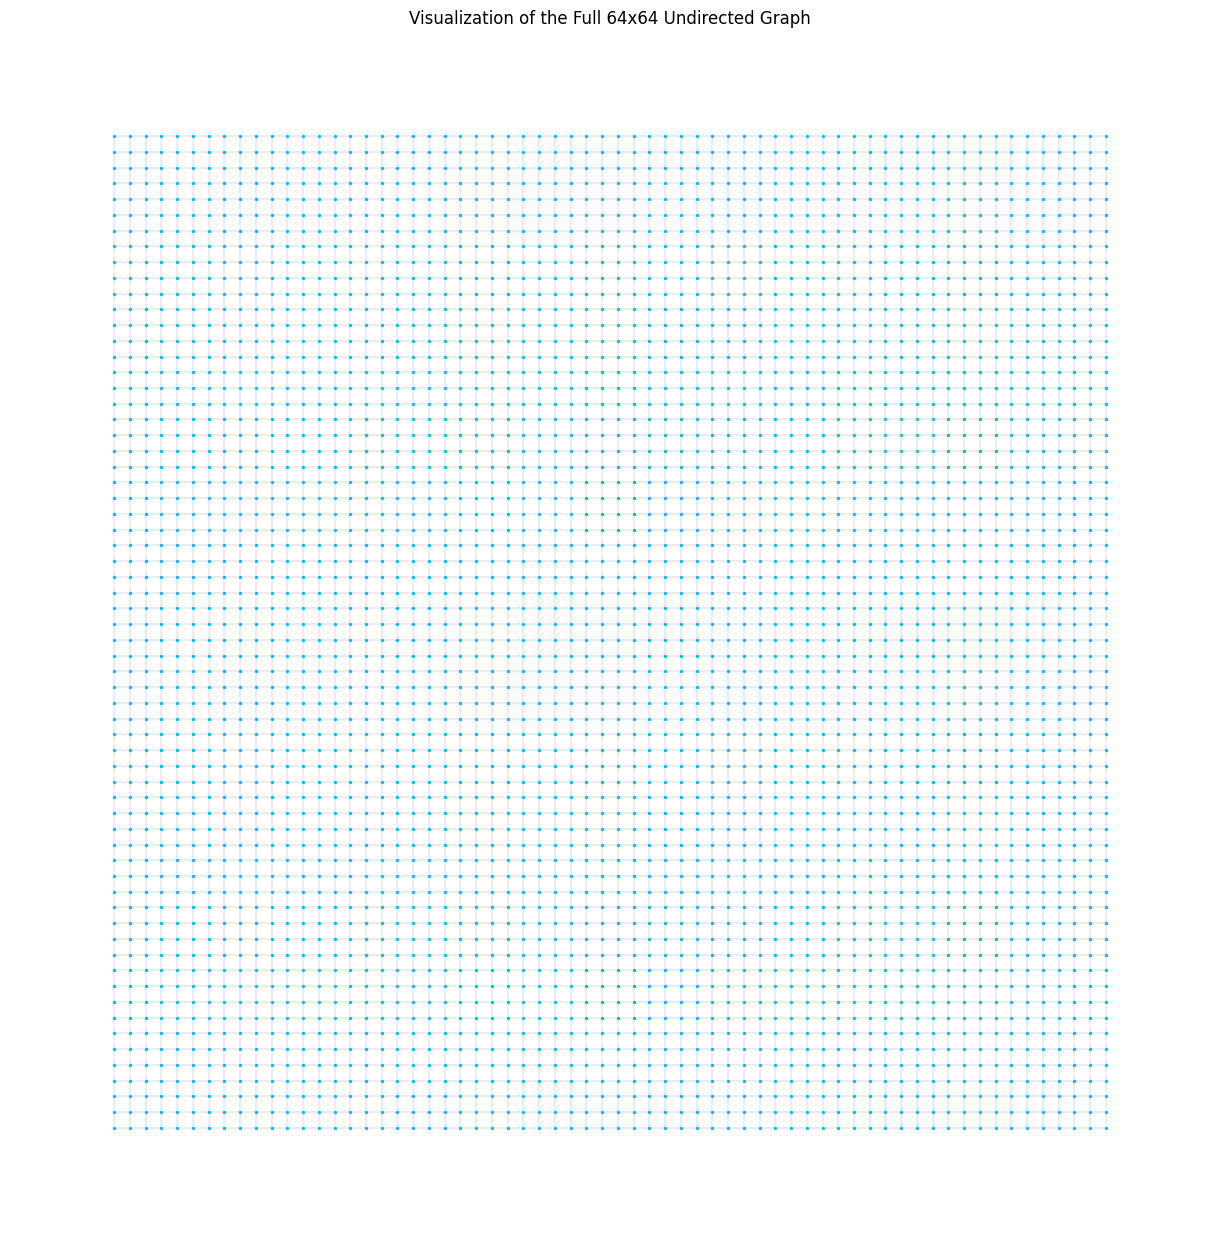

In [13]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from pathlib import Path

def visualize_full_pyg_graph(dataset_path):
    """
    Loads a PyG dataset and visualizes the complete, UNDIRECTED structure 
    of the first graph.
    """
    if not dataset_path.exists():
        print(f"❌ Error: Dataset file not found at '{dataset_path}'")
        return

    # 1. Load the dataset
    print(f"Loading dataset from '{dataset_path}'...")
    pyg_dataset = torch.load(dataset_path, weights_only=False)
    data = pyg_dataset[0] 
    print("Dataset loaded successfully.")

    # 2. Convert the PyG Data object to a NetworkX graph
    print("Converting the full graph to NetworkX format...")
    G = to_networkx(data, node_attrs=['pos'])
    
    # --- THIS IS THE NEW LINE ---
    # Create an undirected version of the graph for plotting
    G = G.to_undirected()
    # --------------------------
    
    # 3. Get the node positions for a grid layout
    pos = nx.get_node_attributes(G, 'pos')

    print("Plotting the full undirected graph... (This may take a moment)")
    plt.figure(figsize=(12, 12))
    
    nx.draw(G, pos, 
            with_labels=False,
            node_size=2,
            width=0.1,
            node_color='deepskyblue')
    
    plt.title("Visualization of the Full 64x64 Undirected Graph")
    plt.show()

# --- Main execution ---
visualize_full_pyg_graph(dataset_file)

Loading dataset from '/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases_processed/normalized_datasets/train_cases_normalized/p_L_125000_rho_L_0.875_train_with_pos_normalized.pt'...
✅ Successfully loaded 30 graphs.

📊 Generating degree histograms for timesteps: [0, 15, 29]...


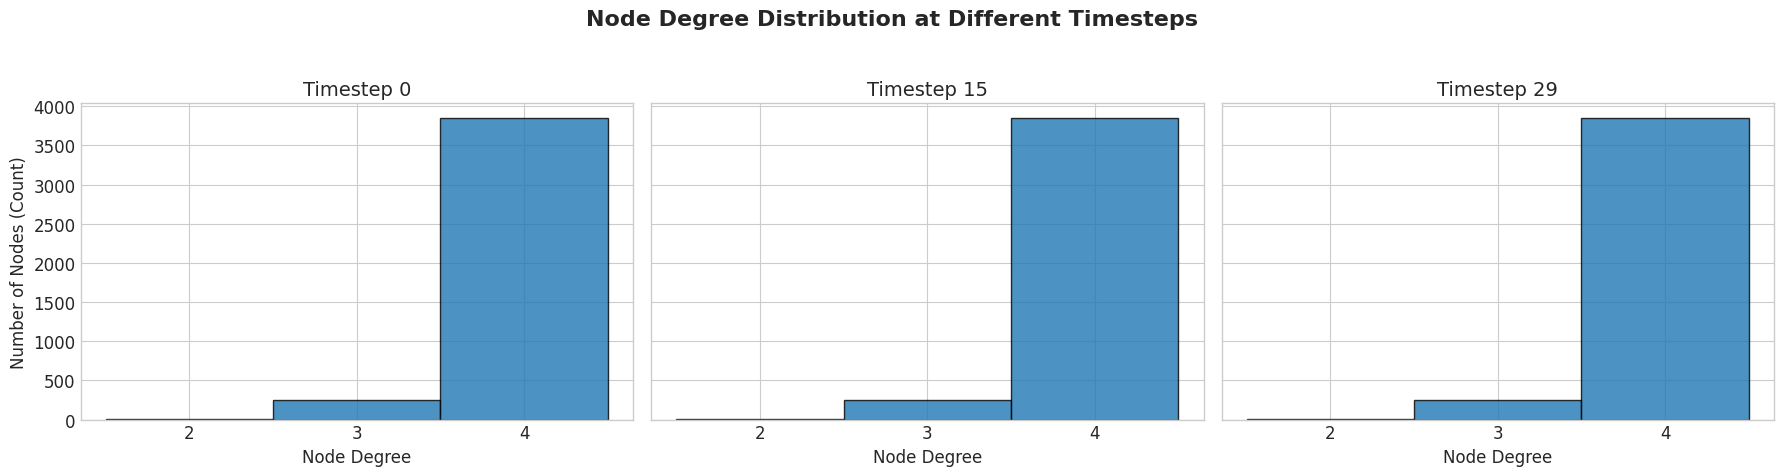

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import warnings

# --- PyTorch Geometric Imports ---
import torch_geometric.data
from torch_geometric.utils import degree
import torch.serialization

# Add the specific PyG class to the safe list to resolve the loading error
torch.serialization.add_safe_globals([
    torch_geometric.data.data.Data,
    torch_geometric.data.data.DataEdgeAttr
])

# Suppress UserWarnings from PyTorch Geometric
warnings.filterwarnings("ignore", category=UserWarning)

# ==============================================================================
# ⚙️ 1. Configuration
# ==============================================================================
# Set the path to your PyTorch Geometric dataset file
# Make sure this is the correct path for your shock_tube.pt file
DATASET_PATH = Path('/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases_processed/normalized_datasets/train_cases_normalized/p_L_125000_rho_L_0.875_train_with_pos_normalized.pt') 

# --- Plotting Style ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'figure.titlesize': 16,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# ==============================================================================
# 🛠️ 2. New Analysis Function: Degree Histogram
# ==============================================================================

def plot_degree_histograms(all_graphs: list, timesteps_to_plot: list):
    """
    Calculates and plots the node degree distribution as a histogram for
    a few specified timesteps.
    """
    print(f"\n📊 Generating degree histograms for timesteps: {timesteps_to_plot}...")

    if not all_graphs:
        print("⚠️ List of graphs is empty. Nothing to analyze.")
        return

    # Create subplots - one for each timestep
    num_plots = len(timesteps_to_plot)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)
    fig.suptitle('Node Degree Distribution at Different Timesteps', fontsize=16, fontweight='bold')

    for i, timestep_idx in enumerate(timesteps_to_plot):
        if timestep_idx >= len(all_graphs):
            print(f"⚠️ Warning: Timestep {timestep_idx} is out of bounds. Skipping.")
            continue

        ax = axes[i]
        graph_data = all_graphs[timestep_idx]

        if graph_data.num_edges == 0:
            ax.set_title(f"Timestep {timestep_idx}\n(No Edges)")
            ax.set_xlabel("Node Degree")
            if i == 0:
                ax.set_ylabel("Number of Nodes")
            continue

        # Use the same robust degree calculation from before
        effective_num_nodes = max(graph_data.num_nodes, graph_data.edge_index.max().item() + 1)
        d = degree(graph_data.edge_index[0], num_nodes=effective_num_nodes)
        
        # Convert to numpy for plotting
        degrees_np = d.cpu().numpy()

        # Plot the histogram
        # Using a specific number of bins can help, especially for integer data.
        # Let's define bins to be centered on integer degrees.
        bins = np.arange(degrees_np.min(), degrees_np.max() + 2) - 0.5
        ax.hist(degrees_np, bins=bins, edgecolor='black', alpha=0.8)
        
        ax.set_title(f"Timestep {timestep_idx}")
        ax.set_xlabel("Node Degree")
        
        # Set major ticks to be integers
        ax.locator_params(axis='x', integer=True)

    axes[0].set_ylabel("Number of Nodes (Count)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

# ==============================================================================
# 🚀 3. Main Execution
# ==============================================================================

def main():
    """Main function to load data and run the analysis."""
    if not DATASET_PATH.exists():
        print(f"❌ Error: Dataset file not found at '{DATASET_PATH}'")
        return

    print(f"Loading dataset from '{DATASET_PATH}'...")
    try:
        with torch.serialization.safe_globals([torch_geometric.data.data.Data, torch_geometric.data.data.DataEdgeAttr]):
             all_graphs = torch.load(DATASET_PATH, weights_only=False)
        
        if not isinstance(all_graphs, list) or not all_graphs:
             print("⚠️ Loaded data is not a valid list of graphs. Please check the file.")
             return
             
        print(f"✅ Successfully loaded {len(all_graphs)} graphs.")
        
    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return

    # --- Define which timesteps to plot ---
    # We'll pick the first, middle, and last timesteps for comparison.
    num_graphs = len(all_graphs)
    timesteps_to_plot = [0, num_graphs // 2, num_graphs - 1]
    
    # --- Run the histogram analysis ---
    plot_degree_histograms(all_graphs, timesteps_to_plot)


# This ensures the script runs when executed
if __name__ == '__main__':
    main()

# Data Processing

# River